<a href="https://colab.research.google.com/github/hisaomlab/Fujita_eLife_2025/blob/main/Omics_analysis_Fujita2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# はじめのお作法（ディスクに接続、ディレクトリ指定、インポート）



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Fujita2025

/content/drive/MyDrive/Fujita2025


In [ ]:
!pip install bioservices

ERROR: Operation cancelled by user


In [ ]:
!pip install matplotlib-venn

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
from scipy.stats import mannwhitneyu
from io import StringIO
from bioservices import KEGG
from scipy.stats import mannwhitneyu, fisher_exact
import requests
import pickle
import requests
from matplotlib_venn import venn2

Creating directory /root/.config/bioservices 


In [ ]:
%ls

2100Proteome_RNA.csv                 norm_Proteome.csv
analyzed_norm_Proteome_2100.csv      pathway_names_dict.pkl
analyzed_norm_Proteome_nonzero.csv   Proteome.csv
analyzed_Proteome_2100.csv           Proteome.xlsx
analyzed_Proteome_for_proteomap.csv  RNAseq.csv
analyzed_Proteome_nonzero.csv        RNAseq_MOXvsMOXYG.csv
FDR_moxYG_RNA_2100Prot.csv           RNAseq.xlsx
Gene_list_for_RNAseq.xlsx            sce_KEGGpathway.xlsx
KEGG_Level.csv


# データフレームの前処理（一度のみ実行）

必要なファイル

*   Proteome.xlsx (Proteome data)
*   RNAseq.xlsx (RNAseq data)
*   KEGG_level.csv (KEGG orthorolgy data)
*   Gene_list_for_RNAseq.xlsx (SGA gene list with brief description)
*   sce_KEGGpathway.xlsx
*   GR_ESR_Rap_list.xls (List of Rapamycin responsive genes)






In [ ]:
# #データフレームの読み込みとLevel結合（一度のみ実行）
#Proteome.csvとRNAseq.csvが書き換えられる

# #くっつけたいデータを読み込み
Level_data =pd.read_csv("KEGG_Level.csv")
SGD_data = pd.read_excel('Gene_list_for_RNAseq.xlsx')

# 'Ribosome biogenesis in eukaryotes' を 'Ribosome biogenesis' に変換
Level_data['Level 3'] = Level_data['Level 3'].replace('Ribosome biogenesis in eukaryotes', 'Ribosome biogenesis')

# #プロテオームデータの前処理
Proteome = pd.read_excel("Proteome.xlsx")
norm_Proteome = Proteome.copy()
norm_Proteome[['moxYG_1', 'moxYG_2', 'moxYG_3']] = Proteome[['moxYG_1', 'moxYG_2', 'moxYG_3']].multiply(0.6)

df1 = pd.merge(Proteome, Level_data, on='ID', how='left')
df1 = pd.merge(df1, SGD_data, on='ID', how='left')
#df1.drop('Gene name', axis=1, inplace=True)
df1.to_csv('Proteome.csv', index=False)

df2 = pd.merge(norm_Proteome , Level_data, on='ID', how='left')
df2 = pd.merge(df2, SGD_data, on='ID', how='left')
#df2.drop('Gene name', axis=1, inplace=True)
df2.to_csv('norm_Proteome.csv', index=False)

# # #RNAseqデータの前処理
RNAseq = pd.read_excel("RNAseq.xlsx")

df3 = pd.merge(RNAseq, Level_data, on='ID', how='left')
df3 = pd.merge(df3, SGD_data, on='ID', how='left')
#df3.drop('Gene_name', axis=1, inplace=True)
df3.to_csv('RNAseq.csv', index=False)

# #RNAseqデータの前処理
# RNAseq = pd.read_excel("MOXvsMOXYG_Re.xlsx")
# df3 = pd.merge(RNAseq, Level_data, on='ID', how='left')
# df3 = pd.merge(df3, SGD_data, on='ID', how='left')
# #df3.drop('Gene_name', axis=1, inplace=True)
# df3.to_csv('RNAseq_MOXvsMOXYG.csv', index=False)

In [ ]:
# # 1) データ読み込み（変数名は DataFrame と区別）
# KEGG_df = pd.read_excel("sce_KEGGpathway.xlsx", header=None,
#                         names=['KEGG_pathway', 'ID'])

# # 2) 「path:」や「sce:」のプレフィックスを削除
# KEGG_df['KEGG_pathway'] = KEGG_df['KEGG_pathway'].str.replace('path:', '', regex=False)
# KEGG_df['ID']            = KEGG_df['ID'].       str.replace('sce:',  '', regex=False)

# # 3) KEGG API クライアントのインスタンス化
# kegg_api = KEGG()

# # 4) 一意な pathway ID リストを取得
# unique_pathway_ids = KEGG_df['KEGG_pathway'].unique()

# # 5) 各 pathway ID を `'map' + 番号` に変えて問い合わせ、名称を辞書化
# pathway_names_dict = {}
# for pid in unique_pathway_ids:
#     map_id = 'map' + pid[3:]           # e.g. 'sce00010' → 'map00010'
#     entry  = kegg_api.get(map_id)      # KEGG REST API から取得
#     parsed = kegg_api.parse(entry)     # 返り値をパース
#     pathway_names_dict[pid] = parsed.get("NAME", "")

# # 6) pickle に保存
# with open('pathway_names_dict.pkl', 'wb') as f:
#     pickle.dump(pathway_names_dict, f)

# プロテオームデータの初期解析（平均値、FDR計算、ヴォルケーノプロット）
Original Figure 5D, Figure 5_S2B,C


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment 

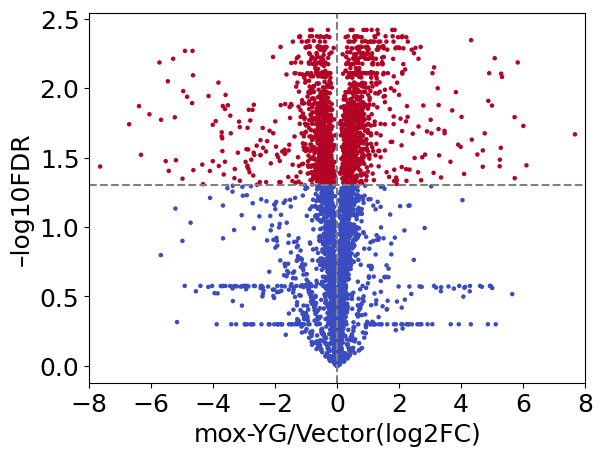

Prot > 0: 872
Prot < 0: 880


In [ ]:
#プロテオームデータ解析（１） 正規化なし・全データ(ゼロ値を2100に)

# データの読み込み
data = pd.read_csv("Proteome.csv")

#最低値を21000に設定
data = data.replace(0, 21000)

# vec, moxそれぞれの平均値のfold changeを計算
data['vec_mean'] = data[['Vec_1', 'Vec_2', 'Vec_3']].mean(axis=1)
data['mox_mean'] = data[['moxYG_1', 'moxYG_2', 'moxYG_3']].mean(axis=1)

# log2 fold change を計算
data['Prot'] = np.log2(data['mox_mean'] / data['vec_mean'])

# p-valueを計算する関数
def calculate_p_value(row):
    vec_values = row[['Vec_1', 'Vec_2', 'Vec_3']].to_numpy(dtype=np.float64)
    mox_values = row[['moxYG_1', 'moxYG_2', 'moxYG_3']].to_numpy(dtype=np.float64)
    p_value = ttest_ind(vec_values, mox_values, equal_var=False)[1]
    return p_value

# 各行に対してt-testのp-valueを計算
data['p_value'] = data.apply(calculate_p_value, axis=1)

# FDRを計算
_, data['Prot_FDR'], _, _ = multipletests(data['p_value'], method='fdr_bh')

# -log10(FDR)を計算
data['-log10_FDR'] = -np.log10(data['Prot_FDR'])

# ボルケーノプロットを描画
plt.scatter(data['Prot'], data['-log10_FDR'], c=(data['Prot_FDR'] <= 0.05), cmap='coolwarm',s=5)
plt.xlabel('mox-YG/Vector(log2FC)')
plt.ylabel('-log10FDR')

# Y軸範囲を-4から4に設定
plt.xlim(-8, 8)
#plt.title('Volcano Plot')
plt.axvline(x=0, linestyle='--', color='gray')
plt.axhline(y=-np.log10(0.05), linestyle='--', color='gray')

# Set the x and y axis label font sizes
plt.xlabel('mox-YG/Vector(log2FC)', fontsize=18)
plt.ylabel('–log10FDR', fontsize=18)

# Set the x and y axis tick label font sizes
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Show the plot
plt.show()

#データフレームの保存
filtered_df = data[['ID', 'Gene_name', 'Level 1', 'Level 2', 'Level 3', 'Prot', 'Prot_FDR', 'Brief description']]
filtered_df.to_csv("analyzed_Proteome_2100.csv",index=False)

# Prot_FDRの値が0.05以下のものをフィルタリングします。
filtered_df = data[data['Prot_FDR'] <= 0.05]

# Protの値が0より大きいものの数をカウントします。
positive_prot_count = filtered_df[filtered_df['Prot'] > 0].shape[0]

# Protの値が0より小さいものの数をカウントします。
negative_prot_count = filtered_df[filtered_df['Prot'] < 0].shape[0]

# 結果をプリントします。
print(f"Prot > 0: {positive_prot_count}")
print(f"Prot < 0: {negative_prot_count}")

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


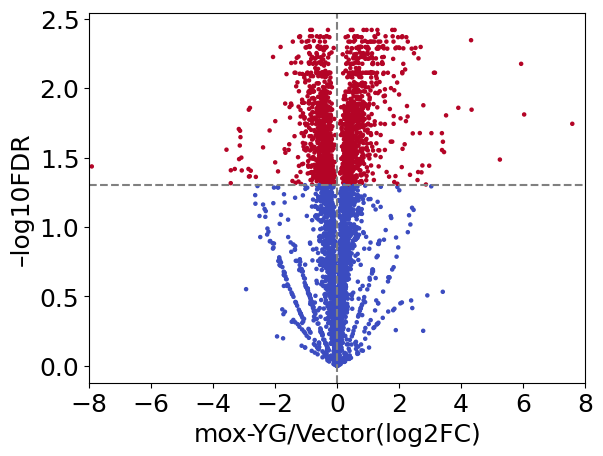

Prot > 0: 870
Prot < 0: 883


In [ ]:
#プロテオームデータ解析（１） 正規化なし・全データ(ゼロ値補正なし) プロテオマップ用1

# データの読み込み
data = pd.read_csv("Proteome.csv")

#最低値を21000に設定
#data = data.replace(0, 21000)

# vec, moxそれぞれの平均値のfold changeを計算
data['vec_mean'] = data[['Vec_1', 'Vec_2', 'Vec_3']].mean(axis=1)
data['mox_mean'] = data[['moxYG_1', 'moxYG_2', 'moxYG_3']].mean(axis=1)

# log2 fold change を計算
data['Prot'] = np.log2(data['mox_mean'] / data['vec_mean'])

# p-valueを計算する関数
def calculate_p_value(row):
    vec_values = row[['Vec_1', 'Vec_2', 'Vec_3']].to_numpy(dtype=np.float64)
    mox_values = row[['moxYG_1', 'moxYG_2', 'moxYG_3']].to_numpy(dtype=np.float64)
    p_value = ttest_ind(vec_values, mox_values, equal_var=False)[1]
    return p_value

# 各行に対してt-testのp-valueを計算
data['p_value'] = data.apply(calculate_p_value, axis=1)

# FDRを計算
_, data['Prot_FDR'], _, _ = multipletests(data['p_value'], method='fdr_bh')

# -log10(FDR)を計算
data['-log10_FDR'] = -np.log10(data['Prot_FDR'])

# ボルケーノプロットを描画
plt.scatter(data['Prot'], data['-log10_FDR'], c=(data['Prot_FDR'] <= 0.05), cmap='coolwarm',s=5)
plt.xlabel('mox-YG/Vector(log2FC)')
plt.ylabel('-log10FDR')

# Y軸範囲を-4から4に設定
plt.xlim(-8, 8)
#plt.title('Volcano Plot')
plt.axvline(x=0, linestyle='--', color='gray')
plt.axhline(y=-np.log10(0.05), linestyle='--', color='gray')

# Set the x and y axis label font sizes
plt.xlabel('mox-YG/Vector(log2FC)', fontsize=18)
plt.ylabel('–log10FDR', fontsize=18)

# Set the x and y axis tick label font sizes
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Show the plot
plt.show()

#データフレームの保存
filtered_df = data[['ID', 'vec_mean','mox_mean','Gene_name', 'Level 1', 'Level 2', 'Level 3', 'Prot', 'Prot_FDR', 'Brief description']]
filtered_df.to_csv("analyzed_Proteome_for_proteomap.csv",index=False)

# Prot_FDRの値が0.05以下のものをフィルタリングします。
filtered_df = data[data['Prot_FDR'] <= 0.05]

# Protの値が0より大きいものの数をカウントします。
positive_prot_count = filtered_df[filtered_df['Prot'] > 0].shape[0]

# Protの値が0より小さいものの数をカウントします。
negative_prot_count = filtered_df[filtered_df['Prot'] < 0].shape[0]

# 結果をプリントします。
print(f"Prot > 0: {positive_prot_count}")
print(f"Prot < 0: {negative_prot_count}")

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


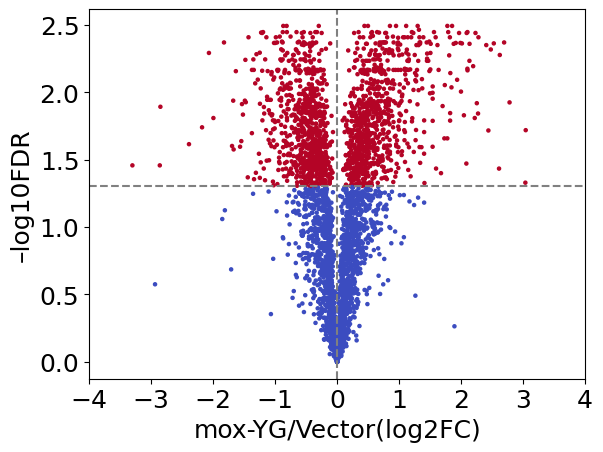

Prot > 0: 842
Prot < 0: 824


In [ ]:
#プロテオームデータ解析（2） 正規化なし・ゼロ値削除

# データの読み込み
data = pd.read_csv("Proteome.csv")

# ゼロ値を含まない行のみを選択
data = data.loc[(data != 0).all(axis=1)]

#最低値を21000に設定
#data = data.replace(0, 21000)

# vec, moxそれぞれの平均値のfold changeを計算
data['vec_mean'] = data[['Vec_1', 'Vec_2', 'Vec_3']].mean(axis=1)
data['mox_mean'] = data[['moxYG_1', 'moxYG_2', 'moxYG_3']].mean(axis=1)

# log2 fold change を計算
data['Prot'] = np.log2(data['mox_mean'] / data['vec_mean'])

# p-valueを計算する関数
def calculate_p_value(row):
    vec_values = row[['Vec_1', 'Vec_2', 'Vec_3']].to_numpy(dtype=np.float64)
    mox_values = row[['moxYG_1', 'moxYG_2', 'moxYG_3']].to_numpy(dtype=np.float64)
    p_value = ttest_ind(vec_values, mox_values, equal_var=False)[1]
    return p_value

# 各行に対してt-testのp-valueを計算
data['p_value'] = data.apply(calculate_p_value, axis=1)

# FDRを計算
_, data['Prot_FDR'], _, _ = multipletests(data['p_value'], method='fdr_bh')

# -log10(FDR)を計算
data['-log10_FDR'] = -np.log10(data['Prot_FDR'])

# ボルケーノプロットを描画
plt.scatter(data['Prot'], data['-log10_FDR'], c=(data['Prot_FDR'] <= 0.05), cmap='coolwarm',s=5)
plt.xlabel('mox-YG/Vector(log2FC)')
plt.ylabel('-log10FDR')

# Y軸範囲を-4から4に設定
plt.xlim(-4, 4)
#plt.title('Volcano Plot')
plt.axvline(x=0, linestyle='--', color='gray')
plt.axhline(y=-np.log10(0.05), linestyle='--', color='gray')

# Set the x and y axis label font sizes
plt.xlabel('mox-YG/Vector(log2FC)', fontsize=18)
plt.ylabel('–log10FDR', fontsize=18)

# Set the x and y axis tick label font sizes
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Show the plot
plt.show()

#データフレームの保存
filtered_df = data[['ID', 'Gene_name', 'Level 1', 'Level 2', 'Level 3', 'Prot', 'Prot_FDR', 'Brief description']]
filtered_df.to_csv("analyzed_Proteome_nonzero.csv",index=False)

# Prot_FDRの値が0.05以下のものをフィルタリングします。
filtered_df = data[data['Prot_FDR'] <= 0.05]

# Protの値が0より大きいものの数をカウントします。
positive_prot_count = filtered_df[filtered_df['Prot'] > 0].shape[0]

# Protの値が0より小さいものの数をカウントします。
negative_prot_count = filtered_df[filtered_df['Prot'] < 0].shape[0]

# 結果をプリントします。
print(f"Prot > 0: {positive_prot_count}")
print(f"Prot < 0: {negative_prot_count}")

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment 

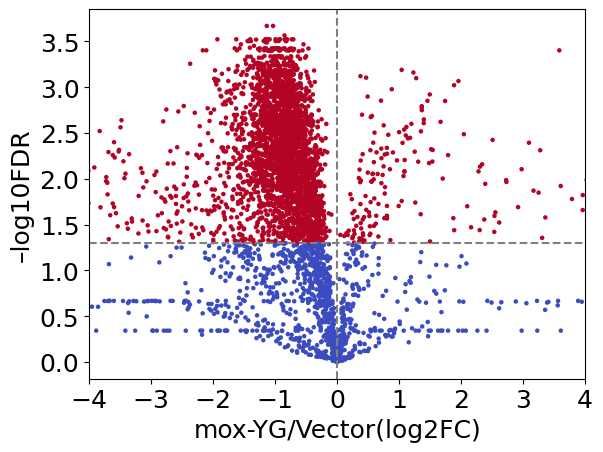

Prot > 0: 177
Prot < 0: 2942


In [ ]:
#プロテオームデータ解析（3） 正規化あり・全データ(ゼロ値を2100に)
#プロテオマップ解析には0値補正なしを使った。

# データの読み込み
data = pd.read_csv("norm_Proteome.csv")

#最低値を21000に設定
data = data.replace(0, 21000)

# vec, moxそれぞれの平均値のfold changeを計算
data['vec_mean'] = data[['Vec_1', 'Vec_2', 'Vec_3']].mean(axis=1)
data['mox_mean'] = data[['moxYG_1', 'moxYG_2', 'moxYG_3']].mean(axis=1)

# log2 fold change を計算
data['Prot'] = np.log2(data['mox_mean'] / data['vec_mean'])

# p-valueを計算する関数
def calculate_p_value(row):
    vec_values = row[['Vec_1', 'Vec_2', 'Vec_3']].to_numpy(dtype=np.float64)
    mox_values = row[['moxYG_1', 'moxYG_2', 'moxYG_3']].to_numpy(dtype=np.float64)
    p_value = ttest_ind(vec_values, mox_values, equal_var=False)[1]
    return p_value

# 各行に対してt-testのp-valueを計算
data['p_value'] = data.apply(calculate_p_value, axis=1)

# FDRを計算
_, data['Prot_FDR'], _, _ = multipletests(data['p_value'], method='fdr_bh')

# -log10(FDR)を計算
data['-log10_FDR'] = -np.log10(data['Prot_FDR'])

# ボルケーノプロットを描画
plt.scatter(data['Prot'], data['-log10_FDR'], c=(data['Prot_FDR'] <= 0.05), cmap='coolwarm',s=5)
plt.xlabel('mox-YG/Vector(log2FC)')
plt.ylabel('-log10FDR')

# Y軸範囲を-4から4に設定
plt.xlim(-4, 4)
#plt.title('Volcano Plot')
plt.axvline(x=0, linestyle='--', color='gray')
plt.axhline(y=-np.log10(0.05), linestyle='--', color='gray')

# Set the x and y axis label font sizes
plt.xlabel('mox-YG/Vector(log2FC)', fontsize=18)
plt.ylabel('–log10FDR', fontsize=18)

# Set the x and y axis tick label font sizes
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Show the plot
plt.show()

#データフレームの保存
filtered_df = data[['ID', 'Gene_name', 'Level 1', 'Level 2', 'Level 3', 'Prot', 'Prot_FDR', 'Brief description']]
filtered_df.to_csv("analyzed_norm_Proteome_2100.csv",index=False)

# Prot_FDRの値が0.05以下のものをフィルタリングします。
filtered_df = data[data['Prot_FDR'] <= 0.05]

# Protの値が0より大きいものの数をカウントします。
positive_prot_count = filtered_df[filtered_df['Prot'] > 0].shape[0]

# Protの値が0より小さいものの数をカウントします。
negative_prot_count = filtered_df[filtered_df['Prot'] < 0].shape[0]

# 結果をプリントします。
print(f"Prot > 0: {positive_prot_count}")
print(f"Prot < 0: {negative_prot_count}")

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


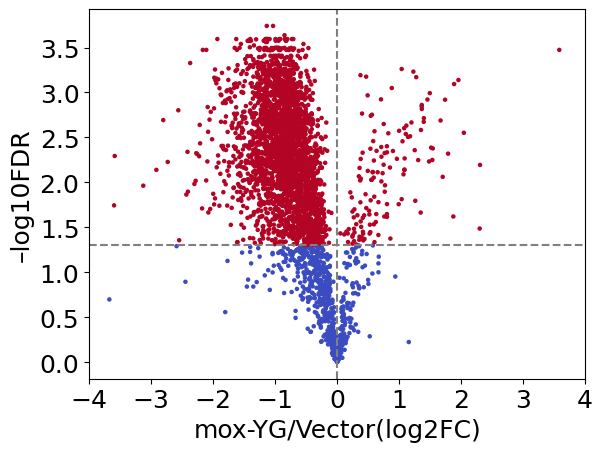

Prot > 0: 138
Prot < 0: 2813


In [ ]:
#プロテオームデータ解析（4） 正規化あり・ゼロ値削除

# データの読み込み
data = pd.read_csv("norm_Proteome.csv")

# ゼロ値を含まない行のみを選択
data = data.loc[(data != 0).all(axis=1)]

# vec, moxそれぞれの平均値のfold changeを計算
data['vec_mean'] = data[['Vec_1', 'Vec_2', 'Vec_3']].mean(axis=1)
data['mox_mean'] = data[['moxYG_1', 'moxYG_2', 'moxYG_3']].mean(axis=1)

# log2 fold change を計算
data['Prot'] = np.log2(data['mox_mean'] / data['vec_mean'])

# p-valueを計算する関数
def calculate_p_value(row):
    vec_values = row[['Vec_1', 'Vec_2', 'Vec_3']].to_numpy(dtype=np.float64)
    mox_values = row[['moxYG_1', 'moxYG_2', 'moxYG_3']].to_numpy(dtype=np.float64)
    p_value = ttest_ind(vec_values, mox_values, equal_var=False)[1]
    return p_value

# 各行に対してt-testのp-valueを計算
data['p_value'] = data.apply(calculate_p_value, axis=1)

# FDRを計算
_, data['Prot_FDR'], _, _ = multipletests(data['p_value'], method='fdr_bh')

# -log10(FDR)を計算
data['-log10_FDR'] = -np.log10(data['Prot_FDR'])

# ボルケーノプロットを描画
plt.scatter(data['Prot'], data['-log10_FDR'], c=(data['Prot_FDR'] <= 0.05), cmap='coolwarm',s=5)
plt.xlabel('mox-YG/Vector(log2FC)')
plt.ylabel('-log10FDR')

# Y軸範囲を-4から4に設定
plt.xlim(-4, 4)
#plt.title('Volcano Plot')
plt.axvline(x=0, linestyle='--', color='gray')
plt.axhline(y=-np.log10(0.05), linestyle='--', color='gray')

# Set the x and y axis label font sizes
plt.xlabel('mox-YG/Vector(log2FC)', fontsize=18)
plt.ylabel('–log10FDR', fontsize=18)

# Set the x and y axis tick label font sizes
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Show the plot
plt.show()

#データフレームの保存
filtered_df = data[['ID', 'Gene_name', 'Level 1', 'Level 2', 'Level 3', 'Prot', 'Prot_FDR', 'Brief description']]
filtered_df.to_csv("analyzed_norm_Proteome_nonzero.csv",index=False)

# Prot_FDRの値が0.05以下のものをフィルタリングします。
filtered_df = data[data['Prot_FDR'] <= 0.05]

# Protの値が0より大きいものの数をカウントします。
positive_prot_count = filtered_df[filtered_df['Prot'] > 0].shape[0]

# Protの値が0より小さいものの数をカウントします。
negative_prot_count = filtered_df[filtered_df['Prot'] < 0].shape[0]

# 結果をプリントします。
print(f"Prot > 0: {positive_prot_count}")
print(f"Prot < 0: {negative_prot_count}")

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


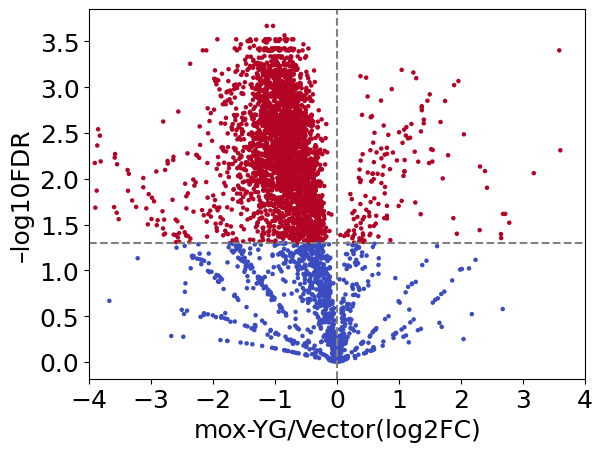

Prot > 0: 176
Prot < 0: 2933


In [ ]:
#プロテオームデータ解析（5） 正規化あり・全データ

# データの読み込み
data = pd.read_csv("norm_Proteome.csv")

# ゼロ値を含まない行のみを選択
# data = data.loc[(data != 0).all(axis=1)]

# vec, moxそれぞれの平均値のfold changeを計算
data['vec_mean'] = data[['Vec_1', 'Vec_2', 'Vec_3']].mean(axis=1)
data['mox_mean'] = data[['moxYG_1', 'moxYG_2', 'moxYG_3']].mean(axis=1)

# log2 fold change を計算
data['Prot'] = np.log2(data['mox_mean'] / data['vec_mean'])

# p-valueを計算する関数
def calculate_p_value(row):
    vec_values = row[['Vec_1', 'Vec_2', 'Vec_3']].to_numpy(dtype=np.float64)
    mox_values = row[['moxYG_1', 'moxYG_2', 'moxYG_3']].to_numpy(dtype=np.float64)
    p_value = ttest_ind(vec_values, mox_values, equal_var=False)[1]
    return p_value

# 各行に対してt-testのp-valueを計算
data['p_value'] = data.apply(calculate_p_value, axis=1)

# FDRを計算
_, data['Prot_FDR'], _, _ = multipletests(data['p_value'], method='fdr_bh')

# -log10(FDR)を計算
data['-log10_FDR'] = -np.log10(data['Prot_FDR'])

# ボルケーノプロットを描画
plt.scatter(data['Prot'], data['-log10_FDR'], c=(data['Prot_FDR'] <= 0.05), cmap='coolwarm',s=5)
plt.xlabel('mox-YG/Vector(log2FC)')
plt.ylabel('-log10FDR')

# Y軸範囲を-4から4に設定
plt.xlim(-4, 4)
#plt.title('Volcano Plot')
plt.axvline(x=0, linestyle='--', color='gray')
plt.axhline(y=-np.log10(0.05), linestyle='--', color='gray')

# Set the x and y axis label font sizes
plt.xlabel('mox-YG/Vector(log2FC)', fontsize=18)
plt.ylabel('–log10FDR', fontsize=18)

# Set the x and y axis tick label font sizes
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Show the plot
plt.show()

#データフレームの保存
filtered_df = data[['ID', 'Gene_name', 'Level 1', 'Level 2', 'Level 3', 'Prot', 'Prot_FDR', 'Brief description']]
filtered_df.to_csv("analyzed_norm_Proteome_nonzero.csv",index=False)

# Prot_FDRの値が0.05以下のものをフィルタリングします。
filtered_df = data[data['Prot_FDR'] <= 0.05]

# Protの値が0より大きいものの数をカウントします。
positive_prot_count = filtered_df[filtered_df['Prot'] > 0].shape[0]

# Protの値が0より小さいものの数をカウントします。
negative_prot_count = filtered_df[filtered_df['Prot'] < 0].shape[0]

# 結果をプリントします。
print(f"Prot > 0: {positive_prot_count}")
print(f"Prot < 0: {negative_prot_count}")

# KEGG orthology (level 3) FDR計算・RNAデータとプロテオームデータの結合

In [ ]:
# moxYG RNA vs Proteome （1） 正規化なし・全データ(ゼロ値を2100に)

#RNAseqデータとProteomeデータの融合
df_RNA = pd.read_excel("RNAseq.xlsx")
df_RNA.rename(columns={'moxYG': 'RNA'}, inplace=True)
df_RNA.rename(columns={'moxYG_FDR': 'RNA_FDR'}, inplace=True)
df_RNA = df_RNA[['ID','RNA','RNA_FDR']]

# proteomeデータ読み込み
df_proteome = pd.read_csv('analyzed_Proteome_2100.csv', delimiter=',')

df = df_proteome.merge(df_RNA, on='ID', how='inner')

#ファイル保存
df.to_csv("2100Proteome_RNA.csv")

#ーーーー

df = df.dropna()

# Level 3カテゴリーの一覧を取得
level3_categories = df['Level 3'].unique()

# 各カテゴリに対してMann-Whitney Uテストを実行し、p値と差分の平均を格納
p_values = []
mean_diffs = []
for category in level3_categories:
    cat_data = df[df['Level 3'] == category]['Prot']
    other_data = df[df['Level 3'] != category]['RNA']

    # Mann-Whitney Uテスト
    _, p_value = mannwhitneyu(cat_data, other_data, alternative='two-sided')
    p_values.append(p_value)

    # 差分の平均を計算
    mean_diff = cat_data.mean() - other_data.mean()
    mean_diffs.append(mean_diff)

# FDR補正を適用
_, corrected_p_values, _, _ = multipletests(p_values, method='fdr_bh')

# 結果をデータフレームに格納
results_df = pd.DataFrame({
    'Level 3': level3_categories,
    'FDR': corrected_p_values,
    'logFC': mean_diffs
})

results_df = results_df.sort_values('FDR')

# 結果を保存
results_df.to_csv("FDR_moxYG_RNA_2100Prot.csv", index=False)


In [ ]:
# moxYG RNA vs Proteome （2）  正規化なし・ゼロ値削除

#RNAseqデータとProteomeデータの融合
df_RNA = pd.read_excel("RNAseq.xlsx")
df_RNA.rename(columns={'moxYG': 'RNA'}, inplace=True)
df_RNA.rename(columns={'moxYG_FDR': 'RNA_FDR'}, inplace=True)
df_RNA = df_RNA[['ID','RNA','RNA_FDR']]

# proteomeデータ読み込み
df_proteome = pd.read_csv('analyzed_Proteome_nonzero.csv', delimiter=',')

df = df_proteome.merge(df_RNA, on='ID', how='inner')

#ファイル保存
df.to_csv("nonzeroProteome_RNA.csv")

#ーーーー

df = df.dropna()

# Level 3カテゴリーの一覧を取得
level3_categories = df['Level 3'].unique()

# 各カテゴリに対してMann-Whitney Uテストを実行し、p値と差分の平均を格納
p_values = []
mean_diffs = []
for category in level3_categories:
    cat_data = df[df['Level 3'] == category]['Prot']
    other_data = df[df['Level 3'] != category]['RNA']

    # Mann-Whitney Uテスト
    _, p_value = mannwhitneyu(cat_data, other_data, alternative='two-sided')
    p_values.append(p_value)

    # 差分の平均を計算
    mean_diff = cat_data.mean() - other_data.mean()
    mean_diffs.append(mean_diff)

# FDR補正を適用
_, corrected_p_values, _, _ = multipletests(p_values, method='fdr_bh')

# 結果をデータフレームに格納
results_df = pd.DataFrame({
    'Level 3': level3_categories,
    'FDR': corrected_p_values,
    'logFC': mean_diffs
})

results_df = results_df.sort_values('FDR')
significant_level3 = [row['Level 3'] for _, row in results_df.iterrows() if row['FDR'] < 0.05]

# 結果を保存
results_df.to_csv("FDR_moxYG_RNA_Prot.csv", index=False)

In [ ]:
# moxYG RNA vs Proteome （3）   正規化あり・全データ(ゼロ値を2100に)

#RNAseqデータとProteomeデータの融合
df_RNA = pd.read_excel("RNAseq.xlsx")
df_RNA.rename(columns={'moxYG': 'RNA'}, inplace=True)
df_RNA.rename(columns={'moxYG_FDR': 'RNA_FDR'}, inplace=True)
df_RNA = df_RNA[['ID','RNA','RNA_FDR']]

# proteomeデータ読み込み
df_proteome = pd.read_csv('analyzed_norm_Proteome_2100.csv', delimiter=',')

df = df_proteome.merge(df_RNA, on='ID', how='inner')

#ファイル保存
df.to_csv("2100norm_Proteome_RNA.csv")

#ーーーー

df = df.dropna()

# Level 3カテゴリーの一覧を取得
level3_categories = df['Level 3'].unique()

# 各カテゴリに対してMann-Whitney Uテストを実行し、p値と差分の平均を格納
p_values = []
mean_diffs = []
for category in level3_categories:
    cat_data = df[df['Level 3'] == category]['Prot']
    other_data = df[df['Level 3'] != category]['RNA']

    # Mann-Whitney Uテスト
    _, p_value = mannwhitneyu(cat_data, other_data, alternative='two-sided')
    p_values.append(p_value)

    # 差分の平均を計算
    mean_diff = cat_data.mean() - other_data.mean()
    mean_diffs.append(mean_diff)

# FDR補正を適用
_, corrected_p_values, _, _ = multipletests(p_values, method='fdr_bh')

# 結果をデータフレームに格納
results_df = pd.DataFrame({
    'Level 3': level3_categories,
    'FDR': corrected_p_values,
    'logFC': mean_diffs
})

results_df = results_df.sort_values('FDR')
significant_level3 = [row['Level 3'] for _, row in results_df.iterrows() if row['FDR'] < 0.05]

# 結果を保存
results_df.to_csv("FDR_moxYG_RNA_normProt2100.csv", index=False)

In [ ]:
# moxYG RNA vs Proteome （4）  正規あり・ゼロ値削除

#RNAseqデータとProteomeデータの融合
df_RNA = pd.read_excel("RNAseq.xlsx")
df_RNA.rename(columns={'moxYG': 'RNA'}, inplace=True)
df_RNA.rename(columns={'moxYG_FDR': 'RNA_FDR'}, inplace=True)
df_RNA = df_RNA[['ID','RNA','RNA_FDR']]

# proteomeデータ読み込み
df_proteome = pd.read_csv('analyzed_norm_Proteome_nonzero.csv', delimiter=',')

df = df_proteome.merge(df_RNA, on='ID', how='inner')

#ファイル保存
df.to_csv("norm_Proteome_RNA.csv")

#ーーーー

df = df.dropna()


# Level 3カテゴリーの一覧を取得
level3_categories = df['Level 3'].unique()

# 各カテゴリに対してMann-Whitney Uテストを実行し、p値と差分の平均を格納
p_values = []
mean_diffs = []
for category in level3_categories:
    cat_data = df[df['Level 3'] == category]['Prot']
    other_data = df[df['Level 3'] != category]['RNA']

    # Mann-Whitney Uテスト
    _, p_value = mannwhitneyu(cat_data, other_data, alternative='two-sided')
    p_values.append(p_value)

    # 差分の平均を計算
    mean_diff = cat_data.mean() - other_data.mean()
    mean_diffs.append(mean_diff)

# FDR補正を適用
_, corrected_p_values, _, _ = multipletests(p_values, method='fdr_bh')

# 結果をデータフレームに格納
results_df = pd.DataFrame({
    'Level 3': level3_categories,
    'FDR': corrected_p_values,
    'logFC': mean_diffs
})

results_df = results_df.sort_values('FDR')

# 結果を保存
results_df.to_csv("FDR_moxYG_RNA_normProt.csv", index=False)

/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:52: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


In [ ]:
# Proteome 正規化あり・ゼロ値削除

# ここにサンプルデータフレーム(df)を作成してください。
df = pd.read_csv('analyzed_norm_Proteome_nonzero.csv', delimiter=',')

df = df.dropna()

# Level 3カテゴリーの一覧を取得
level3_categories = df['Level 3'].unique()

# 各カテゴリに対してMann-Whitney Uテストを実行し、p値と差分の平均を格納
p_values = []
mean_diffs = []
for category in level3_categories:
    cat_data = df[df['Level 3'] == category]['Prot']
    other_data = df[df['Level 3'] != category]['Prot']

    # Mann-Whitney Uテスト
    _, p_value = mannwhitneyu(cat_data, other_data, alternative='two-sided')
    p_values.append(p_value)

    # 差分の平均を計算
    mean_diff = cat_data.mean() - other_data.mean()
    mean_diffs.append(mean_diff)

# FDR補正を適用
_, corrected_p_values, _, _ = multipletests(p_values, method='fdr_bh')

# 結果をデータフレームに格納
results_df = pd.DataFrame({
    'Level 3': level3_categories,
    'FDR': corrected_p_values,
    'logFC': mean_diffs
})

results_df = results_df.sort_values('FDR')

# 結果を保存
results_df.to_csv("FDR_normProt.csv", index=False)

/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:52: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


In [ ]:
# Proteome 正規化なし・ゼロ値削除

# ここにサンプルデータフレーム(df)を作成してください。
df = pd.read_csv('analyzed_Proteome_nonzero.csv', delimiter=',')

df = df.dropna()

# Level 3カテゴリーの一覧を取得
level3_categories = df['Level 3'].unique()

# 各カテゴリに対してMann-Whitney Uテストを実行し、p値と差分の平均を格納
p_values = []
mean_diffs = []
for category in level3_categories:
    cat_data = df[df['Level 3'] == category]['Prot']
    other_data = df[df['Level 3'] != category]['Prot']

    # Mann-Whitney Uテスト
    _, p_value = mannwhitneyu(cat_data, other_data, alternative='two-sided')
    p_values.append(p_value)

    # 差分の平均を計算
    mean_diff = cat_data.mean() - other_data.mean()
    mean_diffs.append(mean_diff)

# FDR補正を適用
_, corrected_p_values, _, _ = multipletests(p_values, method='fdr_bh')

# 結果をデータフレームに格納
results_df = pd.DataFrame({
    'Level 3': level3_categories,
    'FDR': corrected_p_values,
    'logFC': mean_diffs
})

results_df = results_df.sort_values('FDR')

# 結果を保存
results_df.to_csv("FDR_Prot.csv", index=False)

In [ ]:
# mox vs moxYG mRNA

# データを読み込む
df = pd.read_csv("RNAseq.csv").dropna()

# Level 3カテゴリーの一覧を取得
level3_categories = df['Level 3'].unique()

# 各カテゴリに対してMann-Whitney Uテストを実行し、p値と差分の平均を格納
p_values = []
mean_diffs = []
for category in level3_categories:
    mox_data = df[df['Level 3'] == category]['mox']
    moxYG_data = df[df['Level 3'] == category]['moxYG']

    # Mann-Whitney Uテスト
    _, p_value = mannwhitneyu(mox_data, moxYG_data, alternative='two-sided')
    p_values.append(p_value)

    # 差分の平均を計算
    mean_diff = mox_data.mean() - moxYG_data.mean()
    mean_diffs.append(mean_diff)

# FDR補正を適用
_, corrected_p_values, _, _ = multipletests(p_values, method='fdr_bh')

# 結果をデータフレームに格納
results_df = pd.DataFrame({
    'Level 3': level3_categories,
    'FDR': corrected_p_values,
    'logFC': mean_diffs
})

results_df = results_df.sort_values('FDR')

# 結果を保存
results_df.to_csv("FDR_mox_moxYG.csv", index=False)

In [ ]:
# moxYG vs all

# データを読み込む
df = pd.read_csv("RNAseq.csv").dropna()

# Level 3カテゴリーの一覧を取得
level3_categories = df['Level 3'].unique()

# 各カテゴリに対してMann-Whitney Uテストを実行し、p値と差分の平均を格納
p_values = []
mean_diffs = []
for category in level3_categories:
    cat_data = df[df['Level 3'] == category]['moxYG']
    other_data = df[df['Level 3'] != category]['moxYG']

    # Mann-Whitney Uテスト
    _, p_value = mannwhitneyu(cat_data, other_data, alternative='two-sided')
    p_values.append(p_value)

    # 差分の平均を計算
    mean_diff = cat_data.mean() - other_data.mean()
    mean_diffs.append(mean_diff)

# FDR補正を適用
_, corrected_p_values, _, _ = multipletests(p_values, method='fdr_bh')

# 結果をデータフレームに格納
results_df = pd.DataFrame({
    'Level 3': level3_categories,
    'FDR': corrected_p_values,
    'logFC': mean_diffs
})

results_df = results_df.sort_values('FDR')

# 結果を保存
results_df.to_csv("FDR_moxYG_RNA.csv", index=False)

In [ ]:
# mox vs all

# データを読み込む
df = pd.read_csv("RNAseq.csv").dropna()

# Level 3カテゴリーの一覧を取得
level3_categories = df['Level 3'].unique()

# 各カテゴリに対してMann-Whitney Uテストを実行し、p値と差分の平均を格納
p_values = []
mean_diffs = []
for category in level3_categories:
    cat_data = df[df['Level 3'] == category]['mox']
    other_data = df[df['Level 3'] != category]['mox']

    # Mann-Whitney Uテスト
    _, p_value = mannwhitneyu(cat_data, other_data, alternative='two-sided')
    p_values.append(p_value)

    # 差分の平均を計算
    mean_diff = cat_data.mean() - other_data.mean()
    mean_diffs.append(mean_diff)

# FDR補正を適用
_, corrected_p_values, _, _ = multipletests(p_values, method='fdr_bh')

# 結果をデータフレームに格納
results_df = pd.DataFrame({
    'Level 3': level3_categories,
    'FDR': corrected_p_values,
    'logFC': mean_diffs
})

results_df = results_df.sort_values('FDR')

# 結果を保存
results_df.to_csv("FDR_mox_RNA.csv", index=False)

display(results_df)

Level 3           FDR     logFC
29                               Ribosome  2.193353e-20  0.418779
4                   Amino acid metabolism  3.106641e-15 -0.496982
14                             Glycolysis  6.162811e-13 -0.718335
33              Oxidative phosphorylation  7.228553e-12  0.724510
21                      Purine metabolism  7.096612e-06 -0.532940
..                                    ...           ...       ...
75                Glycan binding proteins  9.167109e-01  0.008134
63                      Cellular antigens  9.301111e-01  0.041284
50            Basal transcription factors  9.301111e-01  0.007622
62                        DNA replication  9.855615e-01  0.086263
58  Phosphatidylinositol signaling system  9.855615e-01  0.045190

[76 rows x 3 columns]

# Transcriptome, violin plot, all KEGG category



<ipython-input-83-eb40c5af3b75>:105: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='count'` for the same effect.
  ax = sns.violinplot(x="Category", y='logFC', hue='OP_protein', data=group.assign(Category=name), ax=axs[row, col], scale='count', inner=None, split=True, hue_order=selected_hue_order_1, palette=custom_palette)
<ipython-input-83-eb40c5af3b75>:133: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[row, col].set_xticklabels(axs[row, col].get_xticklabels(), rotation=90)     # X軸のラベルを90度回転
<ipython-input-83-eb40c5af3b75>:105: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='count'` for the same effect.
  ax = sns.violinplot(x="Category", y='logFC', hue='OP_protein', data=group.assign(Category=name), ax=axs[row, col], scale='count', inner=None, split=True, hue_order=selected_hue

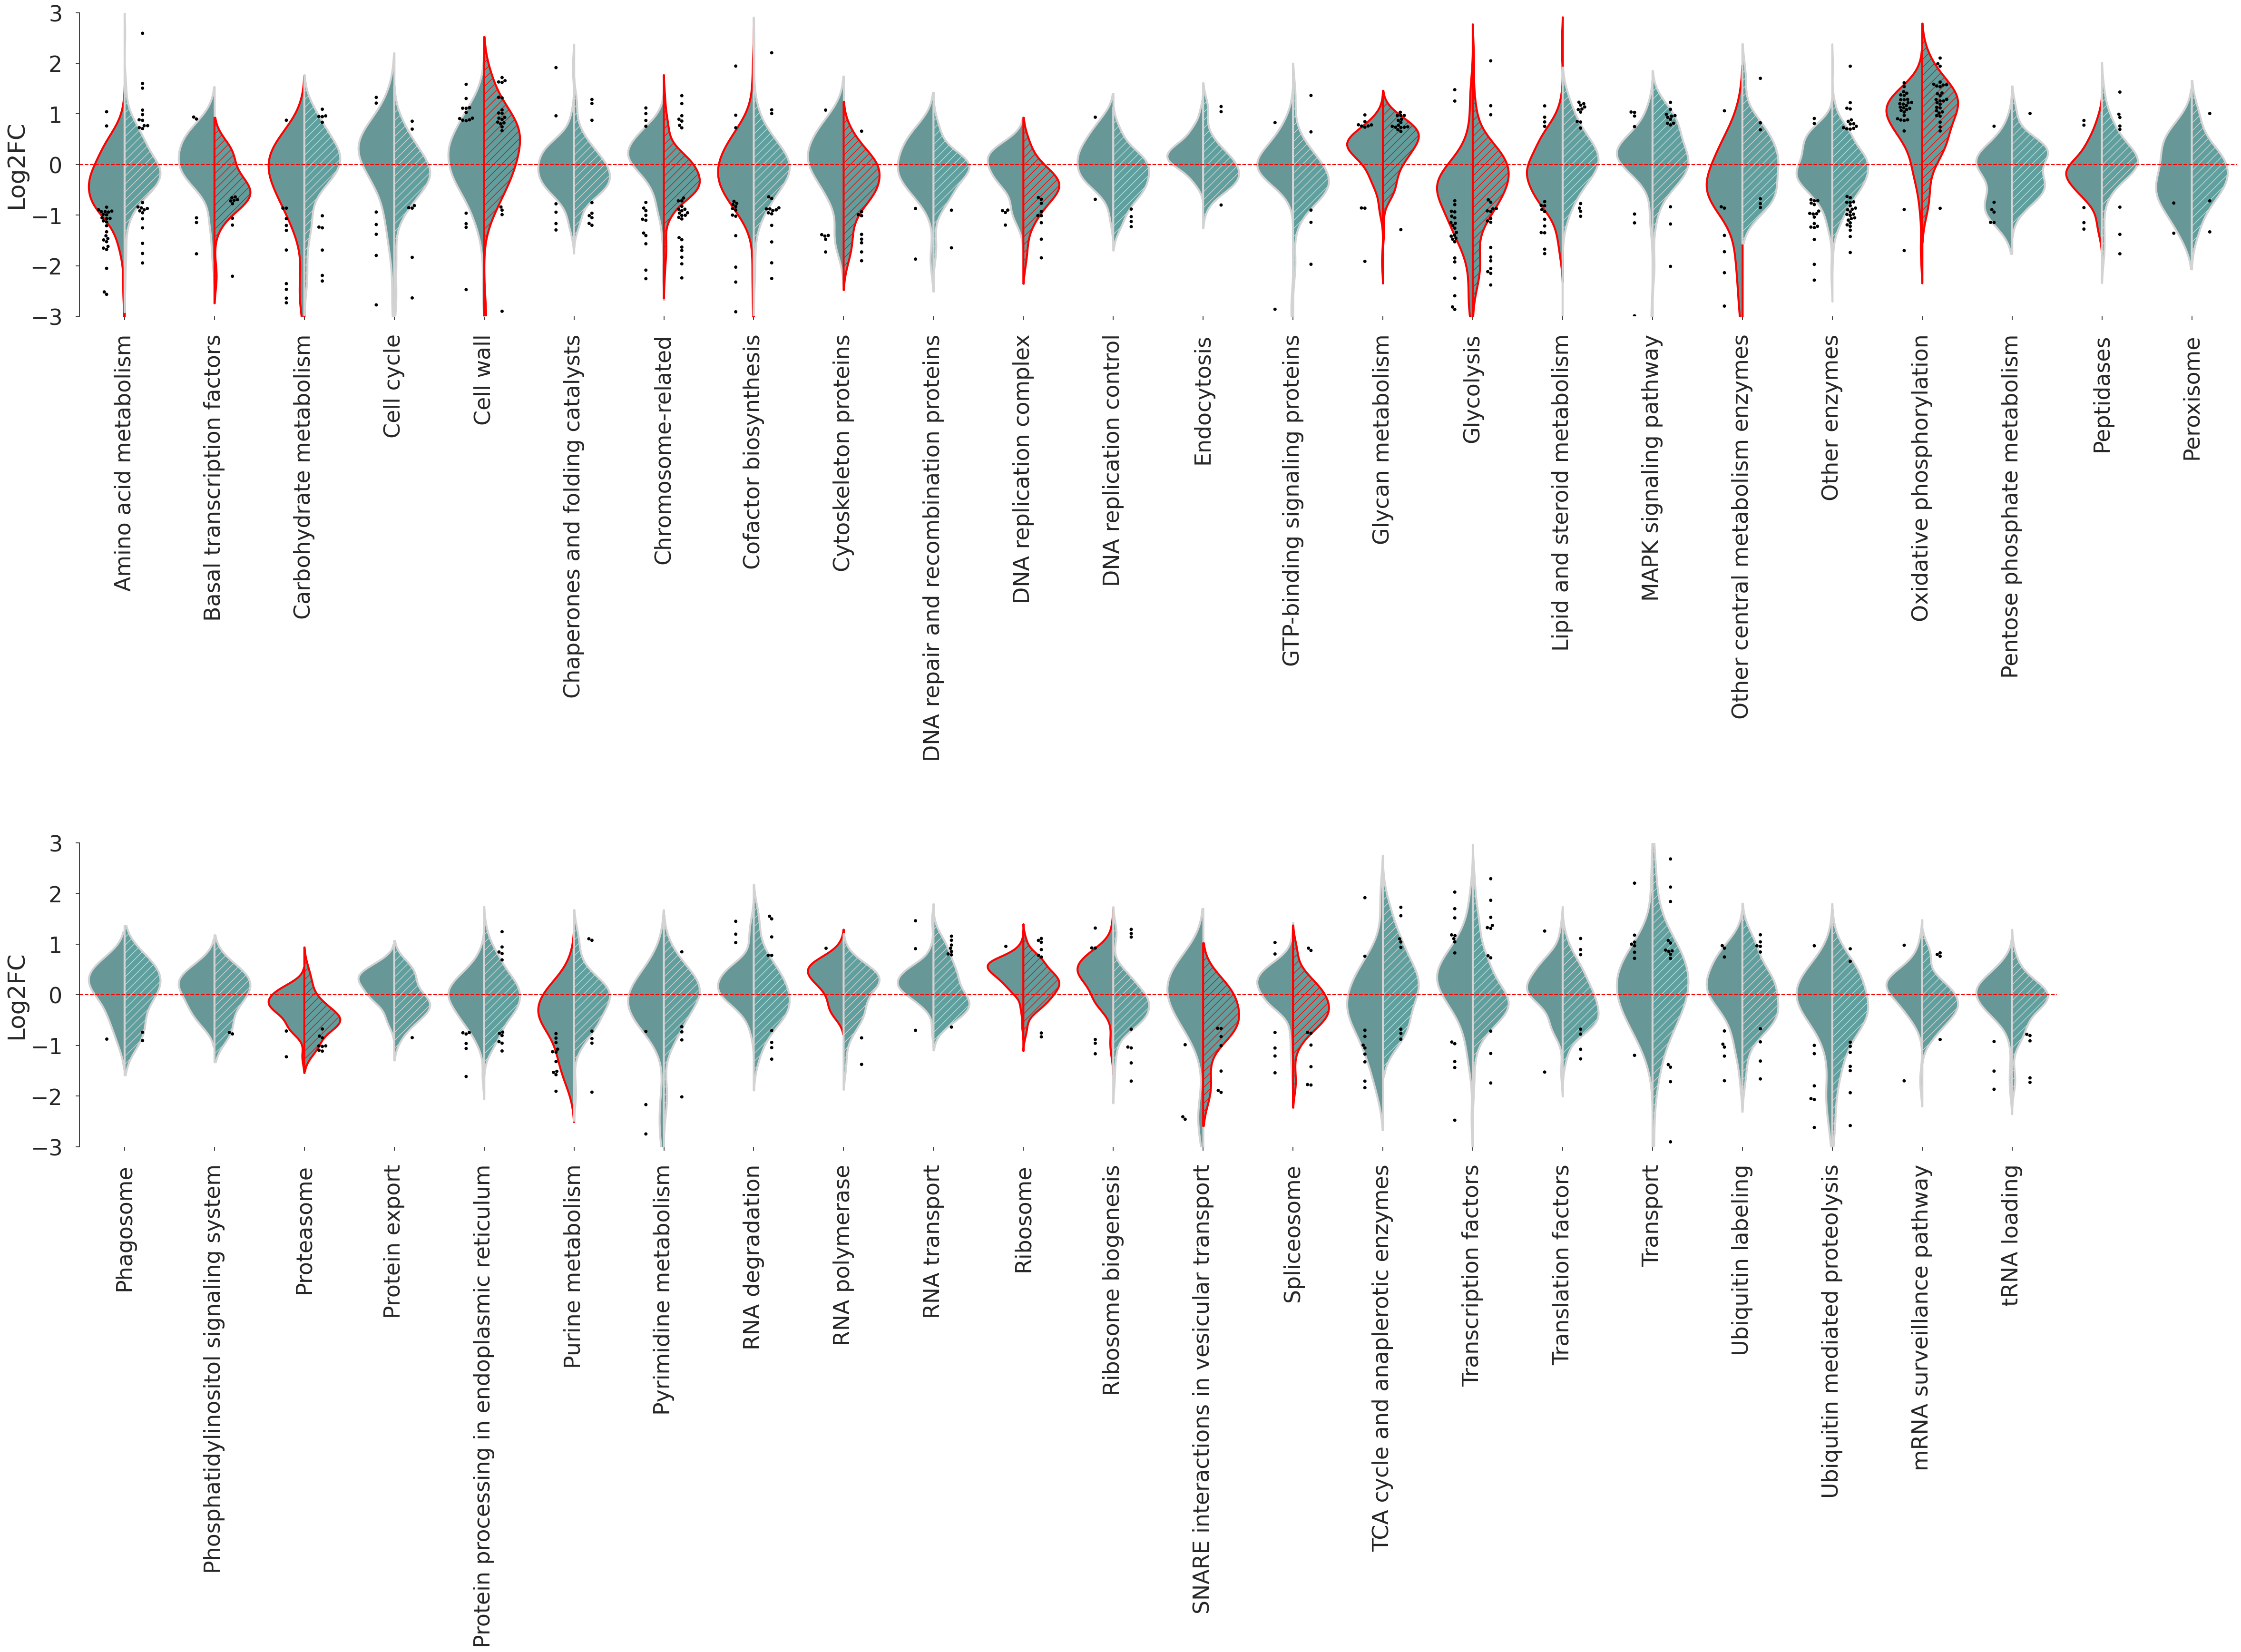

In [ ]:
# mox mRNA vs mox-YG mRNR Leve 3 グラフ作成 Not mapped以外全部

#ーーーー有意差のあるLevel 3カテゴリーだけを抽出ーーーー

#mox RNA
results_df = pd.read_csv('FDR_mox_RNA.csv', delimiter=',')

# Level 3列が 'Not mapped' の行を削除
results_df = results_df[results_df['Level 3'] != 'Not mapped']
significant_mox= results_df[results_df['FDR'] < 0.05]['Level 3'].tolist()

#moxYG RNA
results_df = pd.read_csv('FDR_moxYG_RNA.csv', delimiter=',')

# Level 3列が 'Not mapped' の行を削除
results_df = results_df[results_df['Level 3'] != 'Not mapped']
significant_moxYG= results_df[results_df['FDR'] < 0.05]['Level 3'].tolist()


#ーーーーグラフのためのデータ準備ーーーー

# データを読み込む
df = pd.read_csv('RNAseq.csv', delimiter=',')


#Not mappedを削除
df = df.drop(df[df['Level 3'] == 'Not mapped'].index)

# Level 3 の要素数をカウント
level3_counts = df['Level 3'].value_counts()

# 10以上の要素を持つ Level 3 の要素を抽出
level3_counts_10_or_more = level3_counts[level3_counts >= 10]

# 新しいデータフレームを作成
df = df[df['Level 3'].isin(level3_counts_10_or_more.index)]


# level3_orderを含むデータだけ抽出
#df = df.query('`Level 3` in @level3_order')

# データの整形
# meltの前に、FDR < 0.05 の遺伝子に logFC 値を代入し、それ以外は NaN にする

# Protの logFC に対応する列を別途保持
df['mox_FDR_logFC'] = np.where(df['mox_FDR'] < 0.05, df['mox'], np.nan)
df['moxYG_FDR_logFC'] = np.where(df['moxYG_FDR'] < 0.05, df['moxYG'], np.nan)

# melt に使う列を更新
df_melt = pd.melt(
    df,
    id_vars=['Level 3'],
    value_vars=['mox', 'moxYG', 'mox_FDR_logFC', 'moxYG_FDR_logFC'],
    var_name='OP_protein',
    value_name='logFC'
)

# カテゴリ名の統一（見た目の都合）
df_melt['OP_protein'] = df_melt['OP_protein'].replace({
    'mox_FDR_logFC': 'mox_FDR',
    'moxYG_FDR_logFC': 'moxYG_FDR'
})

# NaNは除く（swarm用）
df_melt = df_melt.dropna(subset=['logFC'])

# pd.Categorical関数を使用して、df内のLevel 3カラムを指定された順序で並べ替える
# df_melt['Level 3'] = pd.Categorical(df_melt['Level 3'], categories=level3_order, ordered=True)


# 並べ替えたカテゴリに基づいて、グループ化されたデータフレームを作成する
grouped = df_melt.groupby('Level 3')
count = len(grouped)

#ーーーーグラフの描画ーーーー

# フォントをArialに設定、サイズを設定
plt.rcParams['font.family'] = 'Helvetica'
sns.set(font_scale=3)


# ヴァイオリンプロットを作成する

sns.set_style('white')
ncols = 24
nrows = math.ceil(count/ncols) +2

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(2*ncols, 15*nrows), sharey=True)

level3_categories = []  # Level 3 カテゴリのリストを初期化

for i, (name, group) in enumerate(grouped):
    row = i // ncols
    col = i % ncols

    level3_categories.append(name)  # Level 3 のカテゴリをリストに追加

    selected_hue_order_1 = ['mox', 'moxYG']
    selected_hue_order_2 = ['mox_FDR', 'moxYG_FDR']
    custom_palette = {'mox': '#5FA09F', 'moxYG':'#5FA09F'}
    custom_palette_2 = {'mox_FDR': 'black', 'moxYG_FDR': 'black'}


    # ヴァイオリンプロットを作成
    ax = sns.violinplot(x="Category", y='logFC', hue='OP_protein', data=group.assign(Category=name), ax=axs[row, col], scale='count', inner=None, split=True, hue_order=selected_hue_order_1, palette=custom_palette)

    # moxYGをストライプに
    for j, violin in enumerate(ax.collections):
        if j % 2 != 0:
            violin.set_hatch('//')
            violin.set_facecolor('#5FA09F')
            violin.set_linewidth(3)

            if name in significant_moxYG:
                violin.set_edgecolor('red')
            else:
                violin.set_edgecolor('lightgray')

        else:
            violin.set_linewidth(3)
            # 有意差あるものの枠線に色をつける
            if name in significant_mox:
                violin.set_edgecolor('red')
            else:
                violin.set_edgecolor("lightgray")


    # スウォームプロットを作成
    sns.swarmplot(x="Category", y='logFC', hue='OP_protein', data=group.assign(Category=name), ax=axs[row, col], dodge=True, hue_order=selected_hue_order_2, palette=custom_palette_2, size=5)

    axs[row, col].set_ylabel('')     #個別のグラフの軸ラベルを消す
    axs[row, col].set_xlabel('')     #個別のグラフの軸ラベルを消す
    axs[row, col].set_xticklabels(axs[row, col].get_xticklabels(), rotation=90)     # X軸のラベルを90度回転

    if col != 0:
        axs[row, col].yaxis.set_ticks_position('none')  # Y軸の目盛り線を削除
        axs[row, col].spines['left'].set_visible(False)  # Y軸の線を削除
        axs[row, col].set_ylabel('')  # Y軸ラベルを削除
    else:
        axs[row, col].yaxis.set_ticks_position('left')  # Y軸の目盛り線を左側に表示
        axs[row, col].set_ylabel('Log2FC')

    axs[row, col].xaxis.set_ticks_position('bottom')
    axs[row, col].spines['bottom'].set_visible(False)  # X軸の線を削除
    axs[row, col].axhline(y=0, color='red', linestyle='--')
    axs[row, col].set_ylim(-3, 3)
    axs[row, col].legend().set_visible(False)
    axs[row, col].tick_params(axis='both', which='both', pad=20) # 軸の目盛りラベルを軸から離す

    # 上部の枠線を非表示にする
    axs[row, col].spines['top'].set_visible(False)
    # 右側の枠線を非表示にする
    axs[row, col].spines['right'].set_visible(False)

for j in range(i + 1, nrows * ncols):
    row = j // ncols
    col = j % ncols
    fig.delaxes(axs[row][col])  # 余分なサブプロットを削除

plt.tight_layout()
#plt.subplots_adjust(wspace=0, hspace=5)  # subplot間の間隔を調整
plt.subplots_adjust(wspace=0)  # subplot間の間隔を調整
#ｐｌｔ.subplots_adjust(bottom=0.8, top=0.9)
plt.show()

# Transcriptome, violin plot, selected KEGG category
positiveとnegative, original Figure 4

<ipython-input-56-6f331ab5fa30>:81: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_melt.groupby('Level 3')
<ipython-input-56-6f331ab5fa30>:113: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='count'` for the same effect.
  ax = sns.violinplot(x="Category", y='logFC', hue='OP_protein', data=group.assign(Category=name), ax=axs[row, col], scale='count',inner=None, split=True, hue_order=selected_hue_order_1, palette=custom_palette)
<ipython-input-56-6f331ab5fa30>:140: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[row, col].set_xticklabels(axs[row, col].get_xticklabels(), rotation=90)     # X軸のラベルを90度回転
<ipython-input-56-6f331ab5fa30>:113: Futur

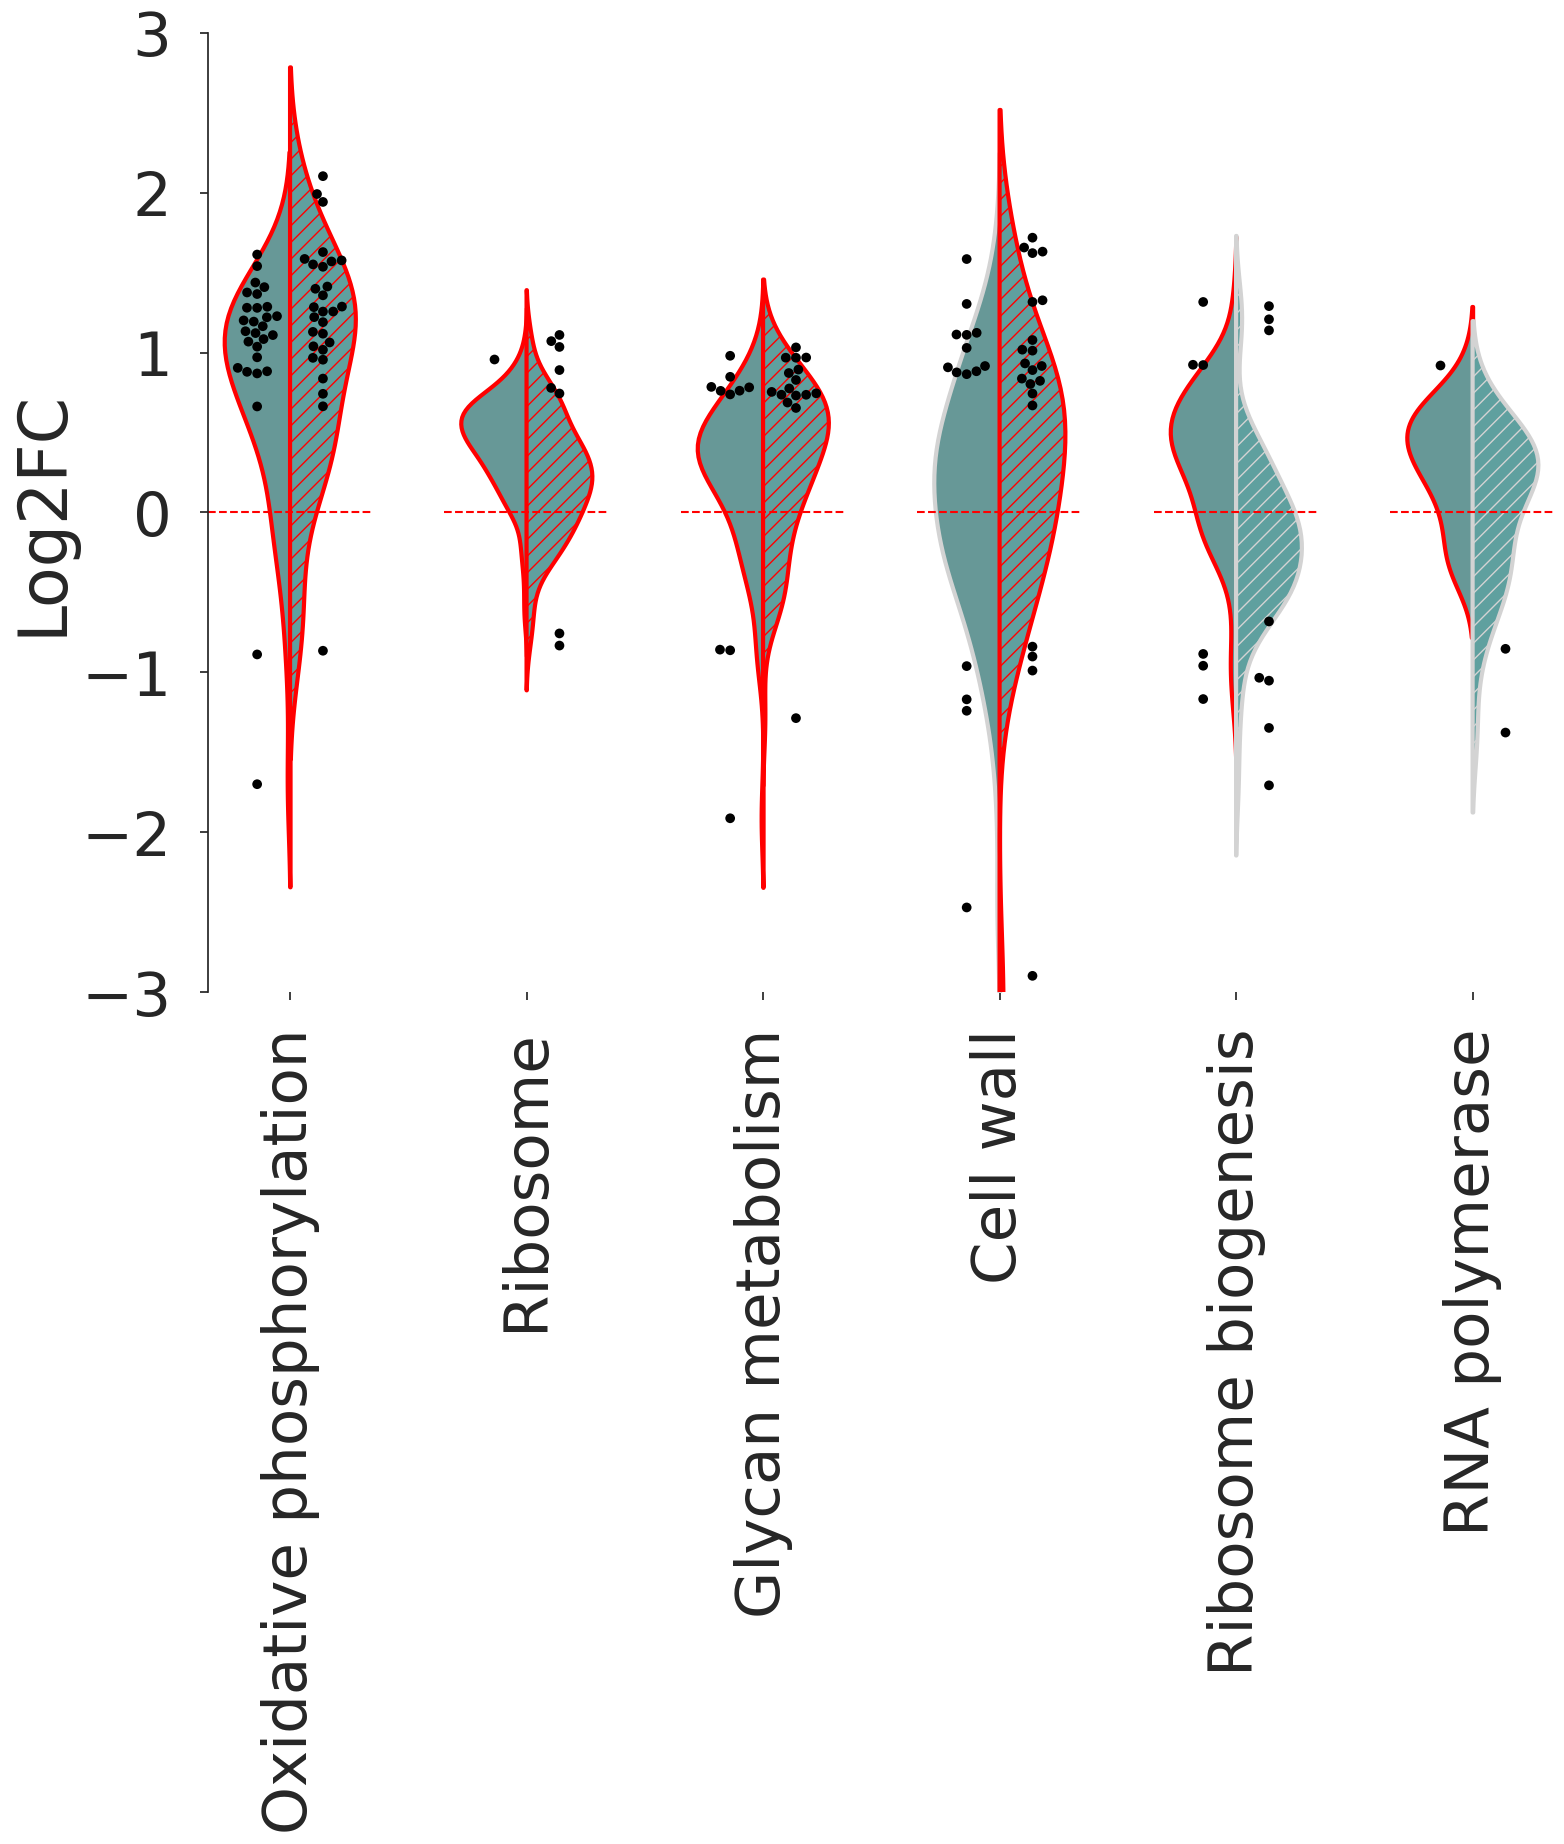

In [ ]:
# mox vs mox-YG mRNA

#ーーーー有意差のあるLevel 3カテゴリーだけを抽出ーーーー

#mox RNA
results_df = pd.read_csv('FDR_mox_RNA.csv', delimiter=',')

# Level 3列が 'Not mapped' の行を削除
results_df = results_df[results_df['Level 3'] != 'Not mapped']
significant_mox= results_df[results_df['FDR'] < 0.05]['Level 3'].tolist()

#moxYG RNA
results_df = pd.read_csv('FDR_moxYG_RNA.csv', delimiter=',')

# Level 3列が 'Not mapped' の行を削除
results_df = results_df[results_df['Level 3'] != 'Not mapped']
significant_moxYG= results_df[results_df['FDR'] < 0.05]['Level 3'].tolist()


#ーーーー表示するLevel 3カテゴリーを選択（mox, moxYGのOR）ーーーー

def process_dataframe(filename):
    results_df = pd.read_csv(filename, delimiter=',')

    # Level 3列が 'Not mapped' の行を削除
    results_df = results_df[results_df['Level 3'] != 'Not mapped']

    # Mean Difference > 0 と Mean Difference < 0 に分ける
    df_positive = results_df[results_df['Mean Difference'] > 0]
    df_negative = results_df[results_df['Mean Difference'] < 0]

    # それぞれをFDRに基づいて昇り順にソートする
    df_positive_sorted = df_positive.sort_values(by='FDR', ascending=True)
    df_negative_sorted = df_negative.sort_values(by='FDR', ascending=True)

    # FDR < 0.05 のLevel 3で2つのリストを作る
    Positive_list = df_positive_sorted[df_positive_sorted['FDR'] < 0.05]['Level 3'].tolist()
    Negative_list = df_negative_sorted[df_negative_sorted['FDR'] < 0.05]['Level 3'].tolist()

    return Positive_list, Negative_list


Positive_list1, Negative_list1 = process_dataframe('FDR_moxYG_RNA.csv')
Positive_list2, Negative_list2 = process_dataframe('FDR_mox_RNA.csv')

# 両ファイルのリストを結合
Positive_list = Positive_list1 + [item for item in Positive_list2 if item not in set(Positive_list1)]
Negative_list = Negative_list1 + [item for item in Negative_list2 if item not in set(Negative_list1)]

#表示するためのリスト作成
level3_order = Positive_list
#level3_order = Negative_list

#ーーーーグラフのためのデータ準備ーーーー

# データを読み込む
df = pd.read_csv('RNAseq.csv', delimiter=',')

#データフレームをスォームプロットのために加工

df.loc[df['mox_FDR'] >= 0.05, 'mox_FDR'] = None
df.loc[df['mox_FDR'] < 0.05, 'mox_FDR'] = df.loc[df['mox_FDR'] < 0.05, 'mox']

df.loc[df['moxYG_FDR'] >= 0.05, 'moxYG_FDR'] = None
df.loc[df['moxYG_FDR'] < 0.05, 'moxYG_FDR'] = df.loc[df['moxYG_FDR'] < 0.05, 'moxYG']

#Not mapped, NaNを削除
df = df.drop(df[df['Level 3'] == 'Not mapped'].index)

# level3_orderを含むデータだけ抽出
df = df.query('`Level 3` in @level3_order')

# データの整形
df_melt = pd.melt(df, id_vars=['Level 3'], value_vars=['mox', 'moxYG','mox_FDR', 'moxYG_FDR'], var_name='OP_protein', value_name='logFC')

# pd.Categorical関数を使用して、df内のLevel 3カラムを指定された順序で並べ替える
df_melt['Level 3'] = pd.Categorical(df_melt['Level 3'], categories=level3_order, ordered=True)

# 並べ替えたカテゴリに基づいて、グループ化されたデータフレームを作成する

grouped = df_melt.groupby('Level 3')
count = len(grouped)


#ーーーーグラフの描画ーーーー

# フォントをArialに設定、サイズを設定
plt.rcParams['font.family'] = 'Helvetica'
sns.set(font_scale=4)

# ヴァイオリンプロットを作成する

sns.set_style('white')
ncols = 20
nrows = math.ceil(count/ncols) +1

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(2.5*ncols, 15*nrows), sharey=True)

level3_categories = []  # Level 3 カテゴリのリストを初期化

for i, (name, group) in enumerate(grouped):
    row = i // ncols
    col = i % ncols

    level3_categories.append(name)  # Level 3 のカテゴリをリストに追加

    selected_hue_order_1 = ['mox', 'moxYG']
    selected_hue_order_2 = ['mox_FDR', 'moxYG_FDR']
    custom_palette = {'mox': '#5FA09F', 'moxYG':'#5FA09F'}
    custom_palette_2 = {'mox_FDR': 'black', 'moxYG_FDR': 'black'}

    # ヴァイオリンプロットを作成
    ax = sns.violinplot(x="Category", y='logFC', hue='OP_protein', data=group.assign(Category=name), ax=axs[row, col], scale='count',inner=None, split=True, hue_order=selected_hue_order_1, palette=custom_palette)

    # moxYGをストライプに
    for j, violin in enumerate(ax.collections):
        if j % 2 != 0:
            violin.set_hatch('//')
            violin.set_facecolor('#5FA09F')
            violin.set_linewidth(3)

            if name in significant_moxYG:
                violin.set_edgecolor('red')
            else:
                violin.set_edgecolor('lightgray')

        else:
            violin.set_linewidth(3)
            # 有意差あるものの枠線に色をつける
            if name in significant_mox:
                violin.set_edgecolor('red')
            else:
                violin.set_edgecolor("lightgray")

    # スウォームプロットを作成
    sns.swarmplot(x="Category", y='logFC', hue='OP_protein', data=group.assign(Category=name), ax=axs[row, col], dodge=True, hue_order=selected_hue_order_2, palette=custom_palette_2, size=7)

    axs[row, col].set_ylabel('')     #個別のグラフの軸ラベルを消す
    axs[row, col].set_xlabel('')     #個別のグラフの軸ラベルを消す
    axs[row, col].set_xticklabels(axs[row, col].get_xticklabels(), rotation=90)     # X軸のラベルを90度回転

    if col != 0:
        axs[row, col].yaxis.set_ticks_position('none')  # Y軸の目盛り線を削除
        axs[row, col].spines['left'].set_visible(False)  # Y軸の線を削除
        axs[row, col].set_ylabel('')  # Y軸ラベルを削除
    else:
        axs[row, col].yaxis.set_ticks_position('left')  # Y軸の目盛り線を左側に表示
        axs[row, col].set_ylabel('Log2FC')

    axs[row, col].xaxis.set_ticks_position('bottom')
    axs[row, col].spines['bottom'].set_visible(False)  # X軸の線を削除
    axs[row, col].axhline(y=0, color='red', linestyle='--')
    axs[row, col].set_ylim(-3, 3)
    axs[row, col].legend().set_visible(False)
    axｓ[row, col].tick_params(axis='both', which='both', pad=20) # 軸の目盛りラベルを軸から離す

    # 上部の枠線を非表示にする
    axs[row, col].spines['top'].set_visible(False)
    # 右側の枠線を非表示にする
    axs[row, col].spines['right'].set_visible(False)

for j in range(i + 1, nrows * ncols):
    row = j // ncols
    col = j % ncols
    fig.delaxes(axs[row][col])  # 余分なサブプロットを削除

plt.tight_layout()
#plt.subplots_adjust(wspace=0, hspace=0.5)  # subplot間の間隔を調整
#plt.subplots_adjust(bottom=0.8, top=12)
plt.show()

#ヴァイオリンプロットを作成（mRNA vs タンパク質）：KEGGカテゴリーを指定

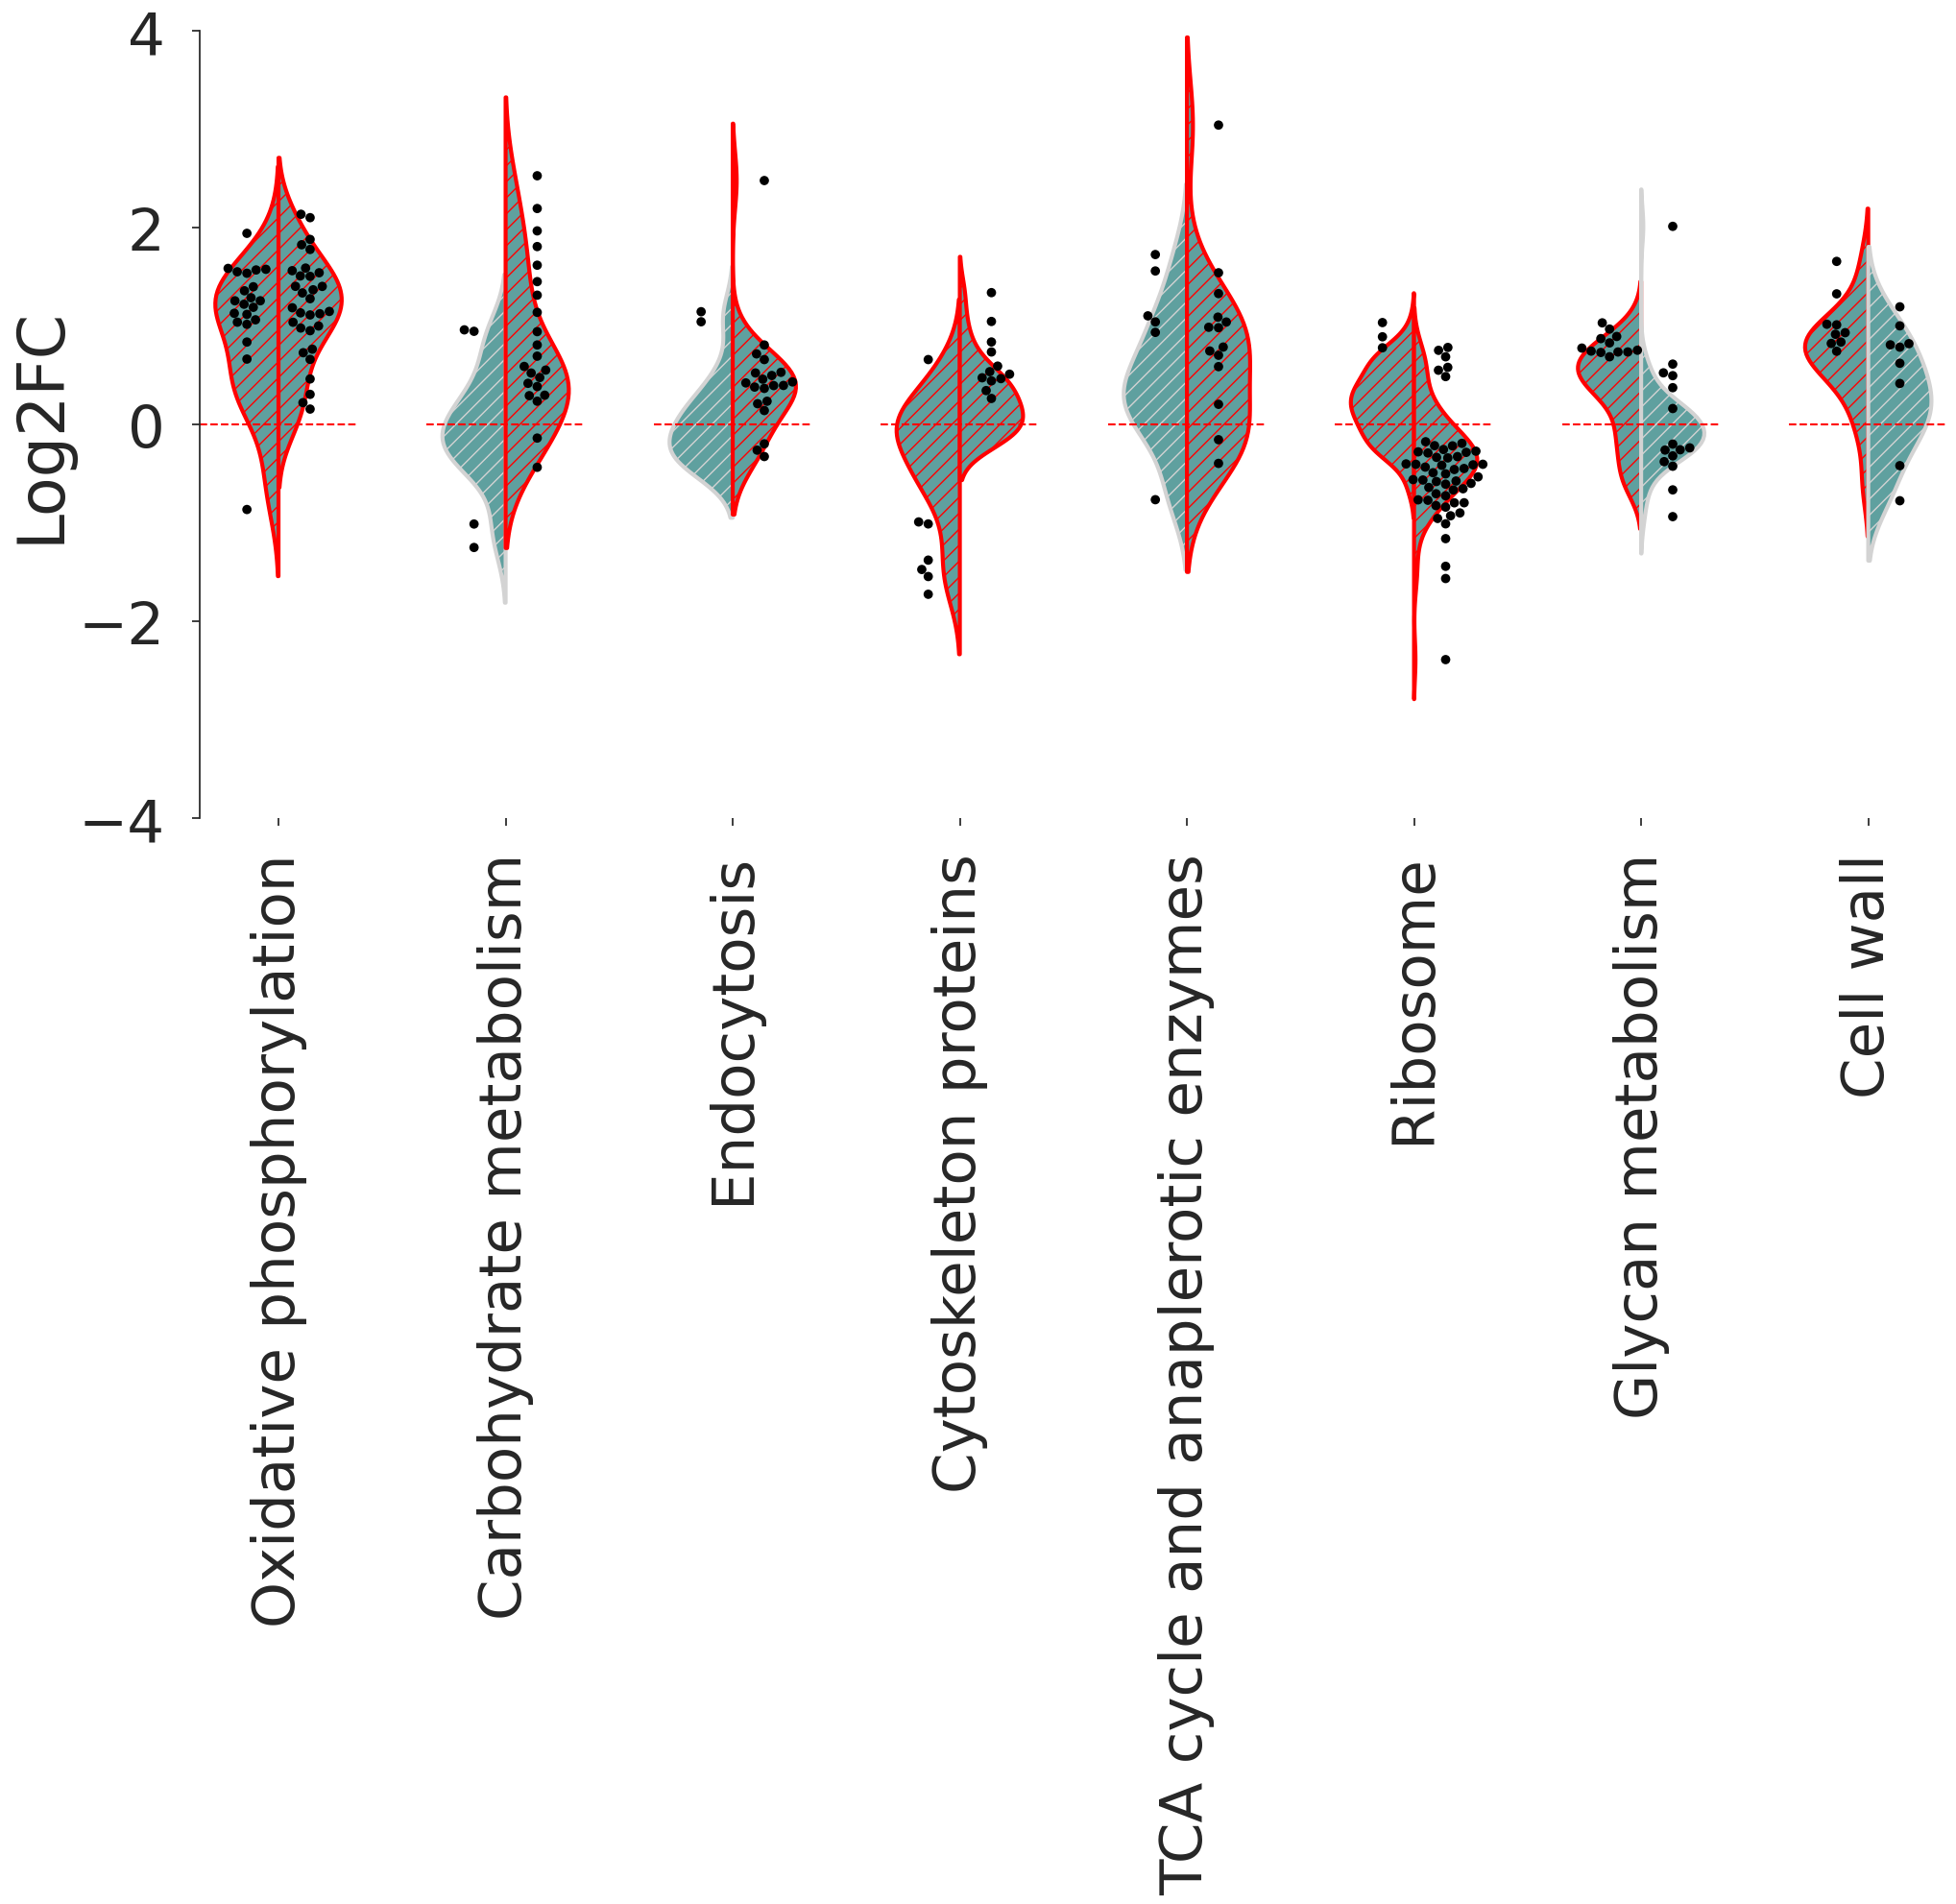

In [ ]:
# mox-YG RNA vs Protein Leve 3 グラフ作成 非正規化ーノンゼロ

#ーーーー有意差のあるLevel 3カテゴリーだけを抽出ーーーー

#タンパク質のリスト
results_df = pd.read_csv('FDR_Prot.csv', delimiter=',')

# Level 3列が 'Not mapped' の行を削除
results_df = results_df[results_df['Level 3'] != 'Not mapped']

significant_Prot = results_df[results_df['FDR'] < 0.05]['Level 3'].tolist()

#RNAのリスト
results_df = pd.read_csv('FDR_moxYG_RNA.csv', delimiter=',')

# Level 3列が 'Not mapped' の行を削除
results_df = results_df[results_df['Level 3'] != 'Not mapped']

significant_RNA= results_df[results_df['FDR'] < 0.05]['Level 3'].tolist()


#ーーーー表示するLevel 3カテゴリーを選択（mox, moxYGのOR）ーーーー

def process_dataframe(filename):
    results_df = pd.read_csv(filename, delimiter=',')

    # Level 3列が 'Not mapped' の行を削除
    results_df = results_df[results_df['Level 3'] != 'Not mapped']

    # Mean Difference > 0 と Mean Difference < 0 に分ける
    df_positive = results_df[results_df['Mean Difference'] > 0]
    df_negative = results_df[results_df['Mean Difference'] < 0]

    # それぞれをFDRに基づいて昇り順にソートする
    df_positive_sorted = df_positive.sort_values(by='FDR', ascending=True)
    df_negative_sorted = df_negative.sort_values(by='FDR', ascending=True)

    # FDR < 0.05 のLevel 3で2つのリストを作る
    Positive_list = df_positive_sorted[df_positive_sorted['FDR'] < 0.05]['Level 3'].tolist()
    Negative_list = df_negative_sorted[df_negative_sorted['FDR'] < 0.05]['Level 3'].tolist()

    return Positive_list, Negative_list

Positive_list1, Negative_list1 = process_dataframe('FDR_Prot.csv')
Positive_list2, Negative_list2 = process_dataframe('FDR_moxYG_RNA.csv')

# 両ファイルのリストを結合
Positive_list = Positive_list1 + [item for item in Positive_list2 if item not in set(Positive_list1)]
Negative_list = Negative_list1 + [item for item in Negative_list2 if item not in set(Negative_list1)]


#表示するためのリスト作成
level3_order = Positive_list
#level3_order = Negative_list


#ーーーーグラフのためのデータ準備ーーーー

# データを読み込む
df = pd.read_csv('nonzeroProteome_RNA.csv', delimiter=',')
#df = pd.read_csv('Proteome_RNA.csv', delimiter=',')

#データフレームをスォームプロットのために加工

df.loc[df['Prot_FDR'] >= 0.05, 'Prot_FDR'] = None
df.loc[df['Prot_FDR'] < 0.05, 'Prot_FDR'] = df.loc[df['Prot_FDR'] < 0.05, 'Prot']

df.loc[df['RNA_FDR'] >= 0.05, 'RNA_FDR'] = None
df.loc[df['RNA_FDR'] < 0.05, 'RNA_FDR'] = df.loc[df['RNA_FDR'] < 0.05, 'RNA']

#Not mappedを削除
df = df.drop(df[df['Level 3'] == 'Not mapped'].index)

# level3_orderを含むデータだけ抽出
df = df.query('`Level 3` in @level3_order')

# データの整形
df_melt = pd.melt(df, id_vars=['Level 3'], value_vars=['RNA', 'Prot','RNA_FDR', 'Prot_FDR'], var_name='OP_protein', value_name='logFC')

# pd.Categorical関数を使用して、df内のLevel 3カラムを指定された順序で並べ替える
df_melt['Level 3'] = pd.Categorical(df_melt['Level 3'], categories=level3_order, ordered=True)

#NaN値エラーを防ぐ
df_melt = df_melt.dropna()

# 並べ替えたカテゴリに基づいて、グループ化されたデータフレームを作成する

grouped = df_melt.groupby('Level 3')
count = len(grouped)


#ーーーーグラフの描画ーーーー

# フォントをArialに設定、サイズを設定
plt.rcParams['font.family'] = 'Helvetica'
sns.set(font_scale=4)

# ヴァイオリンプロットを作成する

sns.set_style('white')
ncols = 20
nrows = math.ceil(count/ncols) +1

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(2.5*ncols, 15*nrows), sharey=True)

level3_categories = []  # Level 3 カテゴリのリストを初期化

for i, (name, group) in enumerate(grouped):
    row = i // ncols
    col = i % ncols

    level3_categories.append(name)  # Level 3 のカテゴリをリストに追加

    selected_hue_order_1 = ['RNA', 'Prot']
    selected_hue_order_2 = ['RNA_FDR', 'Prot_FDR']
    #custom_palette = {'RNA': '#5FA09F', 'Prot':'#5FA09F'}
    custom_palette_2 = {'RNA_FDR': 'black', 'Prot_FDR': 'black'}

    # ヴァイオリンプロットを作成
    ax = sns.violinplot(x="Category", y='logFC', hue='OP_protein', data=group.assign(Category=name), ax=axs[row, col], scale='count', inner=None, split=True, hue_order=selected_hue_order_1)
    #ax = sns.boxplot(x="Category", y='logFC', hue='OP_protein', data=group.assign(Category=name), ax=axs[row, col], hue_order=selected_hue_order_1)

    # moxYGをストライプに
    for j, violin in enumerate(ax.collections):
        if j % 2 != 0:
            violin.set_hatch('//')
            violin.set_facecolor('#5FA09F')
            violin.set_linewidth(3)

            if name in significant_Prot:
                violin.set_edgecolor('red')
            else:
                violin.set_edgecolor('lightgray')

        else:
            violin.set_hatch('//')
            violin.set_facecolor('#5FA09F')
            violin.set_linewidth(3)
            # 有意差あるものの枠線に色をつける
            if name in significant_RNA:
                violin.set_edgecolor('red')
            else:
                violin.set_edgecolor("lightgray")

    # スウォームプロットを作成
    sns.swarmplot(x="Category", y='logFC', hue='OP_protein', data=group.assign(Category=name), ax=axs[row, col], dodge=True, hue_order=selected_hue_order_2, palette=custom_palette_2, size=7)

    axs[row, col].set_ylabel('')     #個別のグラフの軸ラベルを消す
    axs[row, col].set_xlabel('')     #個別のグラフの軸ラベルを消す
    axs[row, col].set_xticklabels(axs[row, col].get_xticklabels(), rotation=90)     # X軸のラベルを90度回転

    if col != 0:
        axs[row, col].yaxis.set_ticks_position('none')  # Y軸の目盛り線を削除
        axs[row, col].spines['left'].set_visible(False)  # Y軸の線を削除
        axs[row, col].set_ylabel('')  # Y軸ラベルを削除
    else:
        axs[row, col].yaxis.set_ticks_position('left')  # Y軸の目盛り線を左側に表示
        axs[row, col].set_ylabel('Log2FC')

    axs[row, col].xaxis.set_ticks_position('bottom')
    axs[row, col].spines['bottom'].set_visible(False)  # X軸の線を削除
    axs[row, col].axhline(y=0, color='red', linestyle='--')
    axs[row, col].set_ylim(-4, 4)
    axs[row, col].legend().set_visible(False)
    axｓ[row, col].tick_params(axis='both', which='both', pad=20) # 軸の目盛りラベルを軸から離す

    # 上部の枠線を非表示にする
    axs[row, col].spines['top'].set_visible(False)
    # 右側の枠線を非表示にする
    axs[row, col].spines['right'].set_visible(False)

for j in range(i + 1, nrows * ncols):
    row = j // ncols
    col = j % ncols
    fig.delaxes(axs[row][col])  # 余分なサブプロットを削除

plt.tight_layout()
#plt.subplots_adjust(wspace=0, hspace=0.5)  # subplot間の間隔を調整
#plt.subplots_adjust(bottom=0.8, top=12)
plt.show()

# Proteome, violin plot, all KEGG category
Original Figure 5_S3

<ipython-input-84-c0d637072bbc>:135: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='count'` for the same effect.
  ax = sns.violinplot(x="Category", y='logFC', hue='OP_protein', data=group.assign(Category=name), ax=axs[row, col], scale='count', inner=None, hue_order=selected_hue_order_1)
<ipython-input-84-c0d637072bbc>:153: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[row, col].set_xticklabels(axs[row, col].get_xticklabels(), rotation=90)     # X軸のラベルを90度回転
<ipython-input-84-c0d637072bbc>:135: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='count'` for the same effect.
  ax = sns.violinplot(x="Category", y='logFC', hue='OP_protein', data=group.assign(Category=name), ax=axs[row, col], scale='count', inner=None, hue_order=selected_hue_order_1)
<ipython-input-84-c0d637072bbc>:153: U

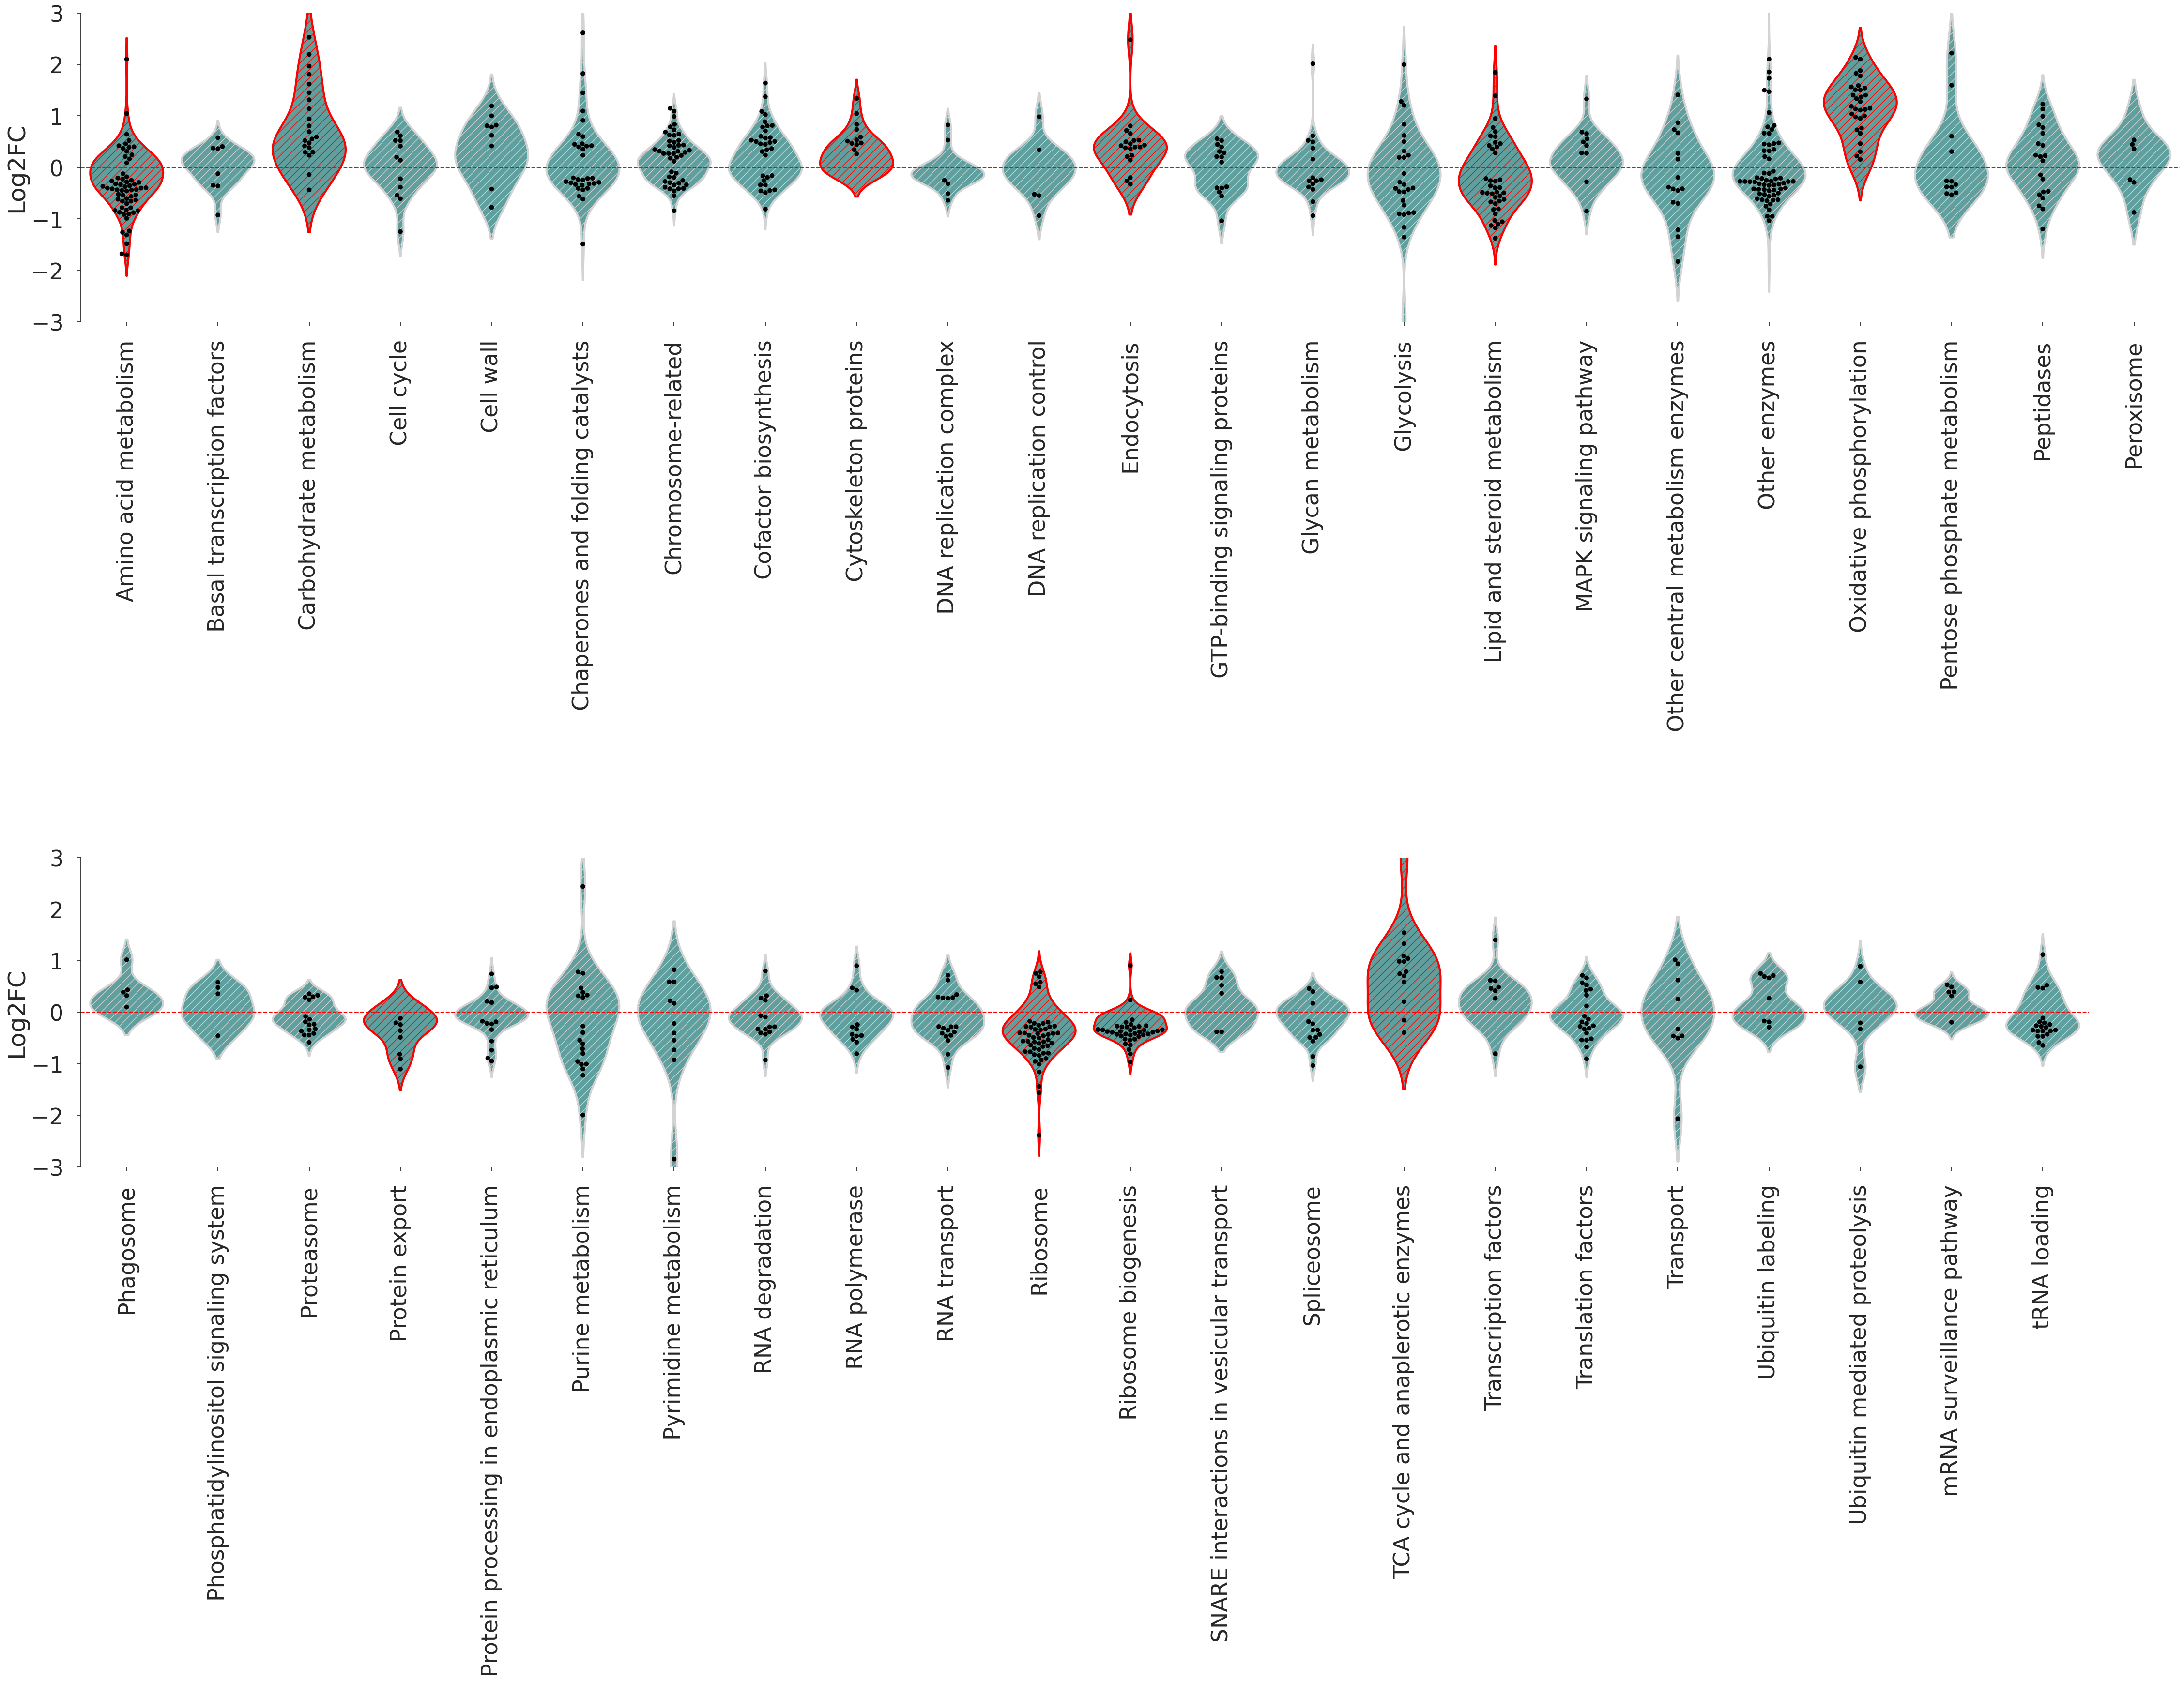

In [ ]:
# Proteome Leve 3 グラフ作成 タンパク質のみ（正規化なし・ゼロ削除・全部）

#ーーーー有意差のあるLevel 3カテゴリーだけを抽出ーーーー

# データフレーム(df)を作成してください。
df = pd.read_csv('analyzed_Proteome_nonzero.csv', delimiter=',')

df = df.dropna()

#RAPリストを読み込む
#RAP = pd.read_excel("GR_ESR_Rap_list.xls")

#RAPデータフレームから、RapがNaNの行を抽出
#filtered_RAP = RAP[(pd.isna(RAP['Rap']))]

# RAPデータフレームから、RapがNaNでない行を抽出
#filtered_RAP = RAP[(~pd.isna(RAP['Rap']))]

# dfデータフレームとfiltered_RAPデータフレームをIDをキーとして結合
#df = df.merge(filtered_RAP, on='ID')

# Level 3カテゴリーの一覧を取得
level3_categories = df['Level 3'].unique()

# 各カテゴリに対してMann-Whitney Uテストを実行し、p値と差分の平均を格納
p_values = []
mean_diffs = []
for category in level3_categories:
    cat_data = df[df['Level 3'] == category]['Prot']
    other_data = df[df['Level 3'] != category]['Prot']

    # Mann-Whitney Uテスト
    _, p_value = mannwhitneyu(cat_data, other_data, alternative='two-sided')
    p_values.append(p_value)

    # 差分の平均を計算
    mean_diff = cat_data.mean() - other_data.mean()
    mean_diffs.append(mean_diff)

# FDR補正を適用
_, corrected_p_values, _, _ = multipletests(p_values, method='fdr_bh')

# 結果をデータフレームに格納
results_df = pd.DataFrame({
    'Level 3': level3_categories,
    'FDR': corrected_p_values,
    'Mean Difference': mean_diffs
})

results_df = results_df.sort_values('FDR')

# Level 3列が 'Not mapped' の行を削除
results_df = results_df[results_df['Level 3'] != 'Not mapped']

significant_Prot = results_df[results_df['FDR'] < 0.05]['Level 3'].tolist()


#ーーーーグラフのためのデータ準備ーーーー

# データを読み込む
df = pd.read_csv('nonzeroProteome_RNA.csv', delimiter=',')

#RAPリストを読み込む
#RAP = pd.read_excel("GR_ESR_Rap_list.xls")

#RAPデータフレームから、RapがNaNの行を抽出
#filtered_RAP = RAP[(pd.isna(RAP['Rap']))]

# RAPデータフレームから、RapがNaNでない行を抽出
#filtered_RAP = RAP[(~pd.isna(RAP['Rap']))]

# dfデータフレームとfiltered_RAPデータフレームをIDをキーとして結合
#df = df.merge(filtered_RAP, on='ID')


#データフレームをスォームプロットのために加工

df.loc[df['Prot_FDR'] >= 0.05, 'Prot_FDR'] = None
df.loc[df['Prot_FDR'] < 0.05, 'Prot_FDR'] = df.loc[df['Prot_FDR'] < 0.05, 'Prot']


#Not mappedを削除
df = df.drop(df[df['Level 3'] == 'Not mapped'].index)


# Level 3 の要素数をカウント
level3_counts = df['Level 3'].value_counts()

# 10以上の要素を持つ Level 3 の要素を抽出
level3_counts_10_or_more = level3_counts[level3_counts >= 10]

# 新しいデータフレームを作成
df = df[df['Level 3'].isin(level3_counts_10_or_more.index)]

# level3_orderを含むデータだけ抽出
#df = df.query('`Level 3` in @level3_order')

# データの整形
df_melt = pd.melt(df, id_vars=['Level 3'], value_vars=['Prot', 'Prot_FDR'], var_name='OP_protein', value_name='logFC')


# 並べ替えたカテゴリに基づいて、グループ化されたデータフレームを作成する

grouped = df_melt.groupby('Level 3')
count = len(grouped)


#ーーーーグラフの描画ーーーー

plt.rcParams['font.family'] = 'Helvetica'
sns.set(font_scale=3)


# ヴァイオリンプロットを作成する

sns.set_style('white')
ncols = 23
nrows = math.ceil(count/ncols) +2

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(2*ncols, 15*nrows), sharey=True)

level3_categories = []  # Level 3 カテゴリのリストを初期化

for i, (name, group) in enumerate(grouped):
    row = i // ncols
    col = i % ncols

    level3_categories.append(name)  # Level 3 のカテゴリをリストに追加

    selected_hue_order_1 = ['Prot']
    selected_hue_order_2 = ['Prot_FDR']
    custom_palette_2 = {'Prot_FDR': 'black'}

    # ヴァイオリンプロットを作成
    ax = sns.violinplot(x="Category", y='logFC', hue='OP_protein', data=group.assign(Category=name), ax=axs[row, col], scale='count', inner=None, hue_order=selected_hue_order_1)

    # moxYGをストライプに
    for j, violin in enumerate(ax.collections):
            violin.set_hatch('//')
            violin.set_facecolor('#5FA09F')
            violin.set_linewidth(3)

            if name in significant_Prot:
                violin.set_edgecolor('red')
            else:
                violin.set_edgecolor('lightgray')

    # スウォームプロットを作成
    sns.swarmplot(x="Category", y='logFC', hue='OP_protein', data=group.assign(Category=name), ax=axs[row, col], dodge=True, hue_order=selected_hue_order_2, palette=custom_palette_2, size=7)

    axs[row, col].set_ylabel('')     #個別のグラフの軸ラベルを消す
    axs[row, col].set_xlabel('')     #個別のグラフの軸ラベルを消す
    axs[row, col].set_xticklabels(axs[row, col].get_xticklabels(), rotation=90)     # X軸のラベルを90度回転

    if col != 0:
        axs[row, col].yaxis.set_ticks_position('none')  # Y軸の目盛り線を削除
        axs[row, col].spines['left'].set_visible(False)  # Y軸の線を削除
        axs[row, col].set_ylabel('')  # Y軸ラベルを削除
    else:
        axs[row, col].yaxis.set_ticks_position('left')  # Y軸の目盛り線を左側に表示
        axs[row, col].set_ylabel('Log2FC')

    axs[row, col].xaxis.set_ticks_position('bottom')
    axs[row, col].spines['bottom'].set_visible(False)  # X軸の線を削除
    axs[row, col].axhline(y=0, color='red', linestyle='--')
    axs[row, col].set_ylim(-3, 3)
    axs[row, col].legend().set_visible(False)
    axｓ[row, col].tick_params(axis='both', which='both', pad=20) # 軸の目盛りラベルを軸から離す

    # 上部の枠線を非表示にする
    axs[row, col].spines['top'].set_visible(False)
    # 右側の枠線を非表示にする
    axs[row, col].spines['right'].set_visible(False)

for j in range(i + 1, nrows * ncols):
    row = j // ncols
    col = j % ncols
    fig.delaxes(axs[row][col])  # 余分なサブプロットを削除

plt.tight_layout()
#plt.subplots_adjust(wspace=0, hspace=5)  # subplot間の間隔を調整
plt.subplots_adjust(wspace=0)  # subplot間の間隔を調整
#ｐｌｔ.subplots_adjust(bottom=0.8, top=0.9)

# Proteome, violin plot, selected KEGG category
Original Figure 5C

In [ ]:
# 有意差のあるLevel3カテゴリーを抽出する関数の定義

import pandas as pd
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

def get_significant_lists(df):
    # Level 3カテゴリーの一覧を取得
    level3_categories = df['Level 3'].unique()

    # 各カテゴリに対してMann-Whitney Uテストを実行し、p値と差分の平均を格納
    p_values = []
    mean_diffs = []
    for category in level3_categories:
        cat_data = df[df['Level 3'] == category]['Prot'].dropna()
        other_data = df[df['Level 3'] != category]['Prot'].dropna()

        # データが空でないことを確認
        if len(cat_data) > 0 and len(other_data) > 0:
            _, p_value = mannwhitneyu(cat_data, other_data, alternative='two-sided')
            p_values.append(p_value)
            mean_diff = cat_data.mean() - other_data.mean()
            mean_diffs.append(mean_diff)
        else:
            p_values.append(np.nan)
            mean_diffs.append(np.nan)

    # p_valuesリストが空でないことを確認
    if len(p_values) > 0:
        _, corrected_p_values, _, _ = multipletests(p_values, method='fdr_bh', is_sorted=False, returnsorted=False)
    else:
        # p_valuesリストが空の場合、補正p値のリストも空とする
        corrected_p_values = []

    results_df = pd.DataFrame({
        'Level 3': level3_categories,
        'FDR': corrected_p_values,
        'Mean Difference': mean_diffs
    })

    results_df = results_df.sort_values('FDR')
    results_df = results_df[results_df['Level 3'] != 'Not mapped']
    significant_Prot = results_df[results_df['FDR'] < 0.05]['Level 3'].tolist()

    df_positive = results_df[results_df['Mean Difference'] > 0]
    df_negative = results_df[results_df['Mean Difference'] < 0]
    df_positive_sorted = df_positive.sort_values(by='FDR', ascending=True)
    df_negative_sorted = df_negative.sort_values(by='FDR', ascending=True)
    Positive_list = df_positive_sorted[df_positive_sorted['FDR'] < 0.05]['Level 3'].tolist()
    Negative_list = df_negative_sorted[df_negative_sorted['FDR'] < 0.05]['Level 3'].tolist()

    return Positive_list, Negative_list, significant_Prot

In [ ]:
# プロットに表示するカテゴリーリストを作成

df_all = pd.read_csv('analyzed_Proteome_nonzero.csv', delimiter=',')
df_all = df_all.dropna()

Positive_all, Negative_all, Significant_Prot_all = get_significant_lists(df_all)

#RAPリストを読み込む
RAP_list = pd.read_excel("GR_ESR_Rap_list.xls")

# RAPデータフレームから、RapがNaNでない行を抽出(Rapamycinで変動しているもの)
Rap = RAP_list[(~pd.isna(RAP_list['Rap']))]

# dfデータフレームとfiltered_RAPデータフレームをIDをキーとして結合
df_Rap = df_all.merge(Rap, on='ID')
Positive_Rap, Negative_Rap, Significant_Prot_Rap = get_significant_lists(df_Rap)

#RAPデータフレームから、RapがNaNの行を抽出(nonRap)
nonRap = RAP_list[(pd.isna(RAP_list['Rap']))]
# dfデータフレームとfiltered_RAPデータフレームをIDをキーとして結合
df_nonRap = df_all.merge(nonRap, on='ID')
Positive_nonRap, Negative_nonRap, Significant_Prot_nonRap = get_significant_lists(df_nonRap)

Negative_list = Negative_all + Negative_Rap + Negative_nonRap
# 重複する要素の削除
Negative_list = list(set(Negative_list))

Positive_list = Positive_all + Positive_Rap + Positive_nonRap
# 重複する要素の削除
Positive_list = list(set(Positive_list))

level3_order = Positive_list + Negative_list
display(level3_order)

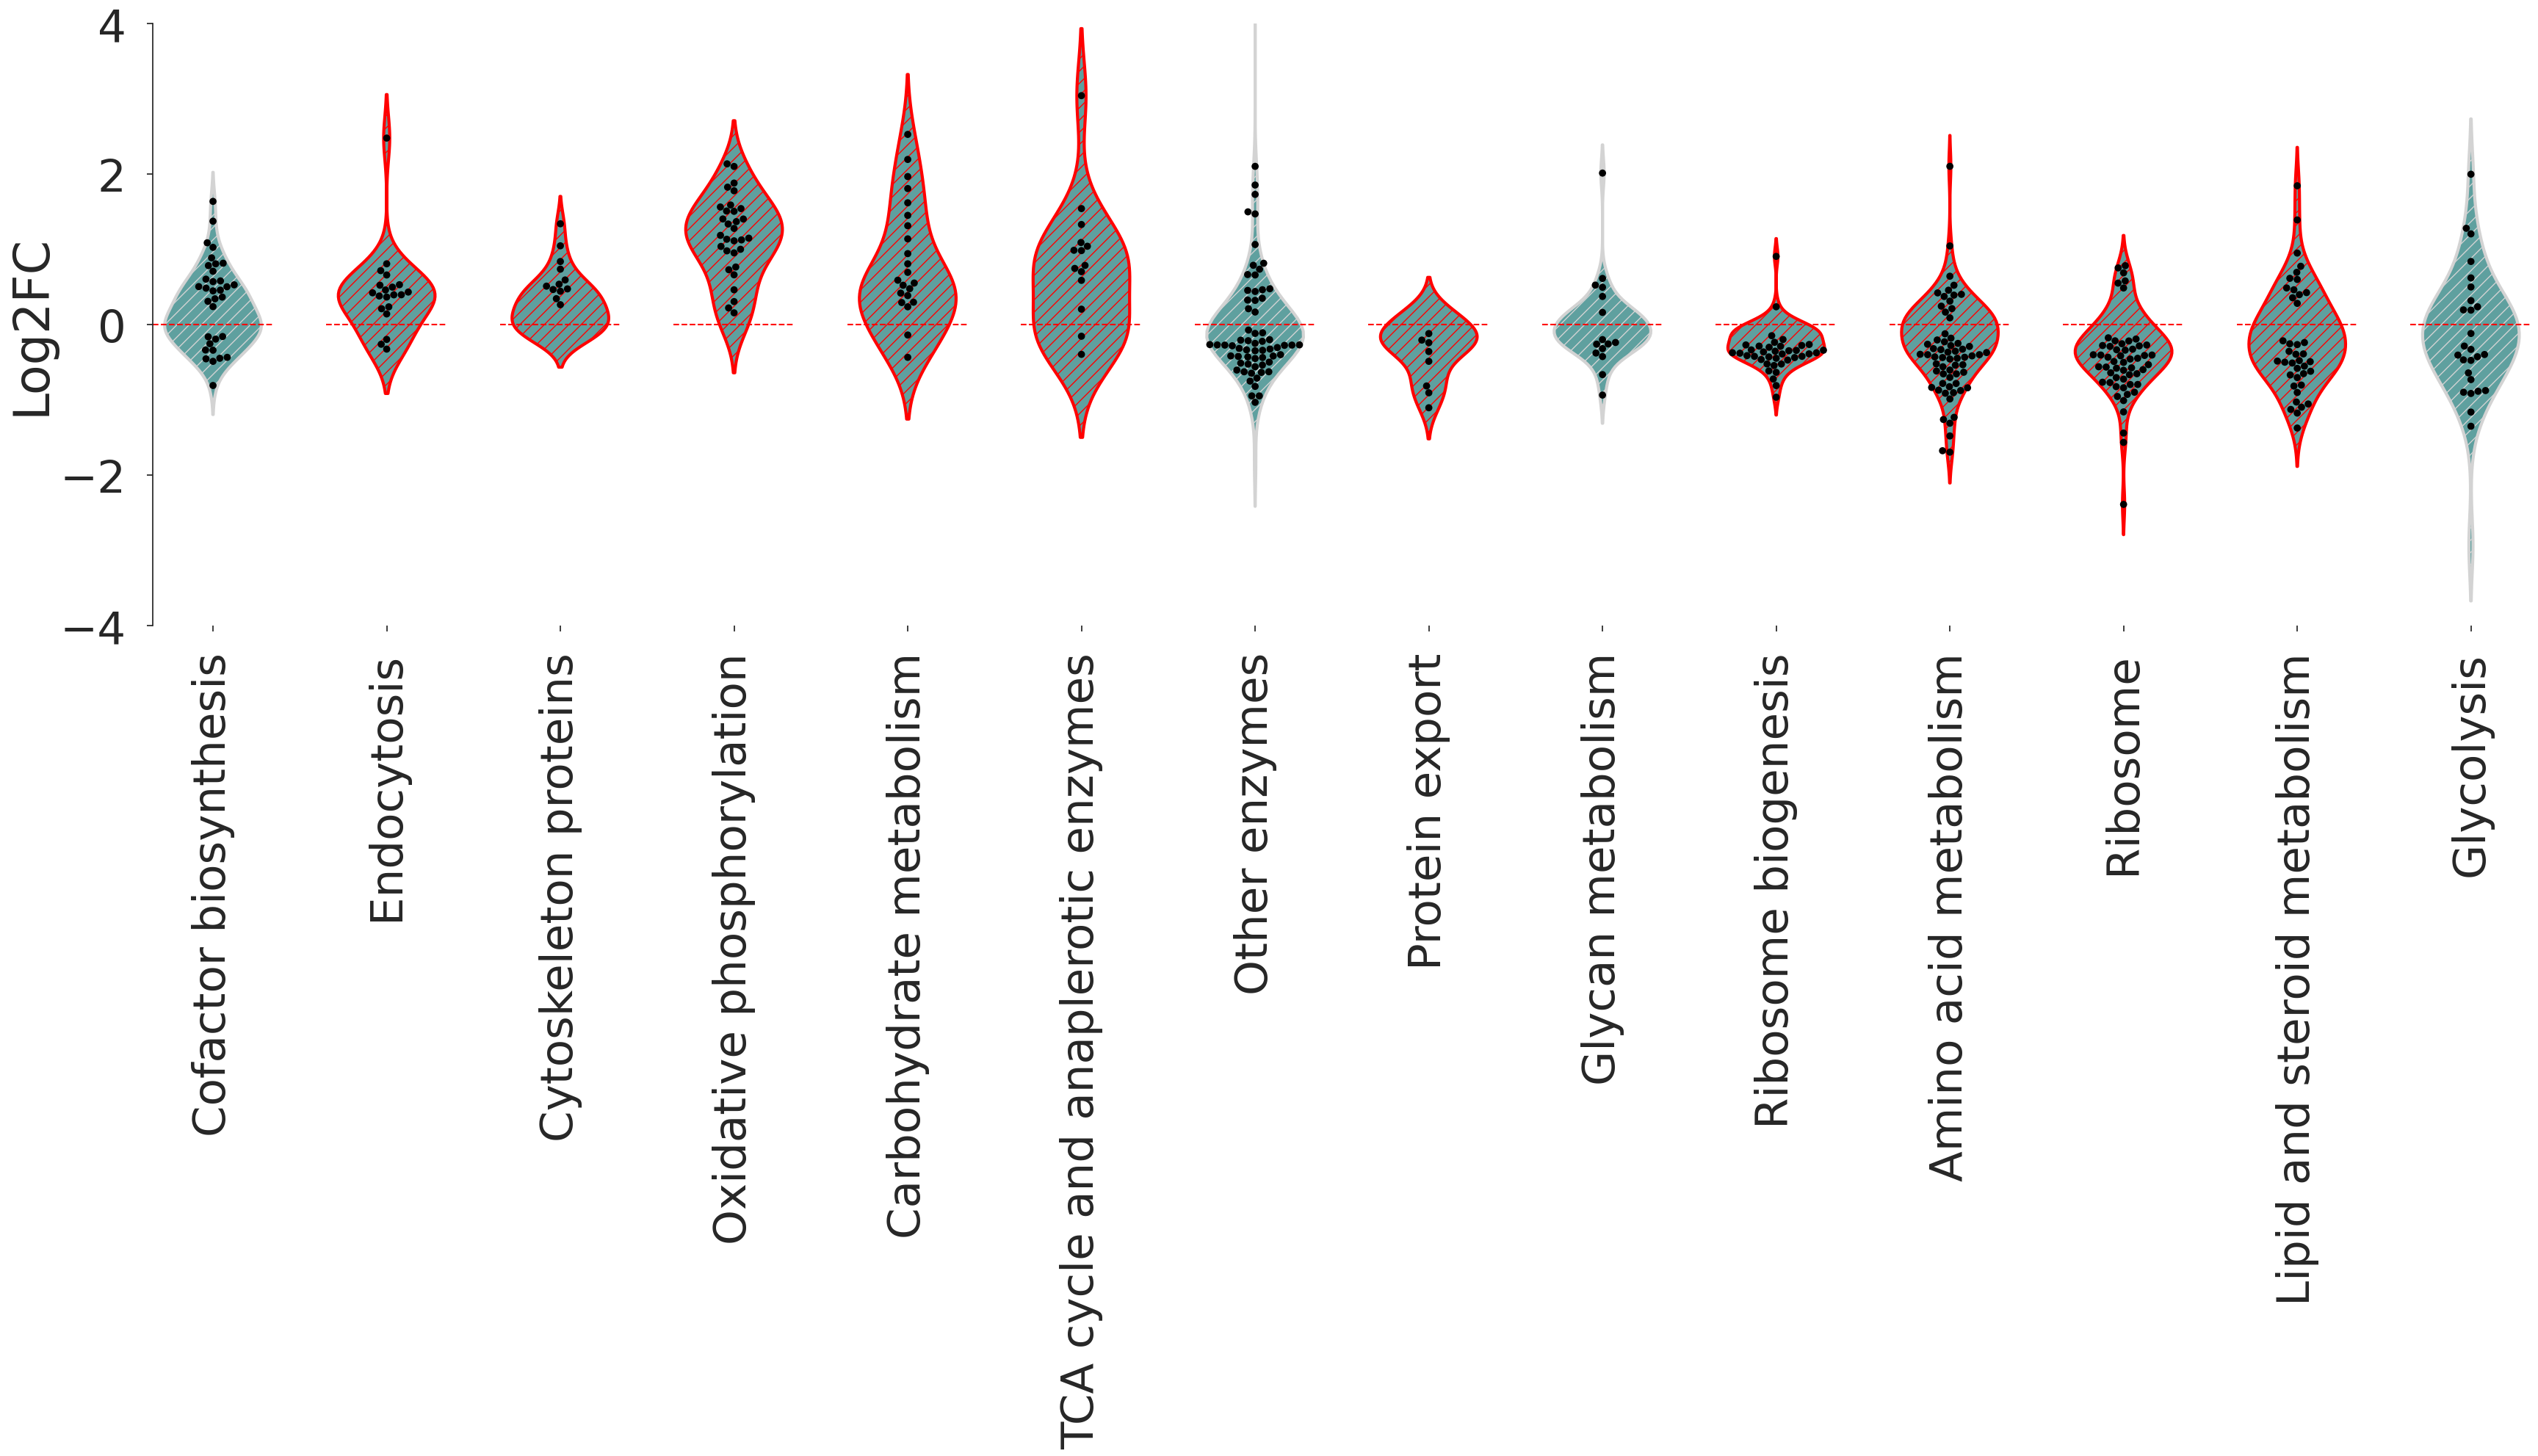

In [ ]:
# 全部のデータでプロット

#ーーーーグラフのためのデータ準備ーーーー

# データを読み込む
df = pd.read_csv('nonzeroProteome_RNA.csv', delimiter=',')
#df = pd.read_csv('Proteome_RNA.csv', delimiter=',')

ｓignificant_Prot = Significant_Prot_all

#RAPリストを読み込む
RAP = pd.read_excel("GR_ESR_Rap_list.xls")

#RAPデータフレームから、RapがNaNの行を抽出
#filtered_RAP = RAP[(pd.isna(RAP['Rap']))]

# RAPデータフレームから、RapがNaNでない行を抽出
#filtered_RAP = RAP[(~pd.isna(RAP['Rap']))]

# dfデータフレームとfiltered_RAPデータフレームをIDをキーとして結合
#df = df.merge(filtered_RAP, on='ID')


#データフレームをスォームプロットのために加工

df.loc[df['Prot_FDR'] >= 0.05, 'Prot_FDR'] = None
df.loc[df['Prot_FDR'] < 0.05, 'Prot_FDR'] = df.loc[df['Prot_FDR'] < 0.05, 'Prot']

#Not mappedを削除
df = df.drop(df[df['Level 3'] == 'Not mapped'].index)

# level3_orderを含むデータだけ抽出
df = df.query('`Level 3` in @level3_order')

# データの整形
df_melt = pd.melt(df, id_vars=['Level 3'], value_vars=['Prot', 'Prot_FDR'], var_name='OP_protein', value_name='logFC')

# pd.Categorical関数を使用して、df内のLevel 3カラムを指定された順序で並べ替える
df_melt['Level 3'] = pd.Categorical(df_melt['Level 3'], categories=level3_order, ordered=True)

#NaN値エラーを防ぐ
df_melt = df_melt.dropna()

# 並べ替えたカテゴリに基づいて、グループ化されたデータフレームを作成する

grouped = df_melt.groupby('Level 3')
count = len(grouped)


#ーーーーグラフの描画ーーーー

# フォントをArialに設定、サイズを設定
plt.rcParams['font.family'] = 'Helvetica'
sns.set(font_scale=4)

# ヴァイオリンプロットを作成する

sns.set_style('white')
ncols = 20
nrows = math.ceil(count/ncols) +1

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(2.5*ncols, 15*nrows), sharey=True)

level3_categories = []  # Level 3 カテゴリのリストを初期化

for i, (name, group) in enumerate(grouped):
    row = i // ncols
    col = i % ncols

    level3_categories.append(name)  # Level 3 のカテゴリをリストに追加

    selected_hue_order_1 = ['Prot']
    selected_hue_order_2 = ['Prot_FDR']
    custom_palette_2 = {'Prot_FDR': 'black'}

    # ヴァイオリンプロットを作成
    ax = sns.violinplot(x="Category", y='logFC', hue='OP_protein', data=group.assign(Category=name), ax=axs[row, col], scale='count', inner=None, hue_order=selected_hue_order_1)

    # moxYGをストライプに
    for j, violin in enumerate(ax.collections):
            violin.set_hatch('//')
            violin.set_facecolor('#5FA09F')
            violin.set_linewidth(3)

            if name in significant_Prot:
                violin.set_edgecolor('red')
            else:
                violin.set_edgecolor('lightgray')

    # スウォームプロットを作成
    sns.swarmplot(x="Category", y='logFC', hue='OP_protein', data=group.assign(Category=name), ax=axs[row, col], dodge=True, hue_order=selected_hue_order_2, palette=custom_palette_2, size=7)

    axs[row, col].set_ylabel('')     #個別のグラフの軸ラベルを消す
    axs[row, col].set_xlabel('')     #個別のグラフの軸ラベルを消す
    axs[row, col].set_xticklabels(axs[row, col].get_xticklabels(), rotation=90)     # X軸のラベルを90度回転

    if col != 0:
        axs[row, col].yaxis.set_ticks_position('none')  # Y軸の目盛り線を削除
        axs[row, col].spines['left'].set_visible(False)  # Y軸の線を削除
        axs[row, col].set_ylabel('')  # Y軸ラベルを削除
    else:
        axs[row, col].yaxis.set_ticks_position('left')  # Y軸の目盛り線を左側に表示
        axs[row, col].set_ylabel('Log2FC')

    axs[row, col].xaxis.set_ticks_position('bottom')
    axs[row, col].spines['bottom'].set_visible(False)  # X軸の線を削除
    axs[row, col].axhline(y=0, color='red', linestyle='--')
    axs[row, col].set_ylim(-4, 4)
    axs[row, col].legend().set_visible(False)
    axｓ[row, col].tick_params(axis='both', which='both', pad=20) # 軸の目盛りラベルを軸から離す

    # 上部の枠線を非表示にする
    axs[row, col].spines['top'].set_visible(False)
    # 右側の枠線を非表示にする
    axs[row, col].spines['right'].set_visible(False)

for j in range(i + 1, nrows * ncols):
    row = j // ncols
    col = j % ncols
    fig.delaxes(axs[row][col])  # 余分なサブプロットを削除

plt.tight_layout()
#plt.subplots_adjust(wspace=0, hspace=0.5)  # subplot間の間隔を調整
#plt.subplots_adjust(bottom=0.8, top=12)
plt.show()

# Protein、Rap nonRapをくっつけたバイオリンプロット 有意差あるカテゴリーのみ
Original Figure 5_S4A, B


In [ ]:
# 有意差のあるLevel3カテゴリーを抽出する関数の定義

import pandas as pd
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

def get_significant_lists(df):
    # Level 3カテゴリーの一覧を取得
    level3_categories = df['Level 3'].unique()

    # 各カテゴリに対してMann-Whitney Uテストを実行し、p値と差分の平均を格納
    p_values = []
    mean_diffs = []
    for category in level3_categories:
        cat_data = df[df['Level 3'] == category]['Prot'].dropna()
        other_data = df[df['Level 3'] != category]['Prot'].dropna()

        # データが空でないことを確認
        if len(cat_data) > 0 and len(other_data) > 0:
            _, p_value = mannwhitneyu(cat_data, other_data, alternative='two-sided')
            p_values.append(p_value)
            mean_diff = cat_data.mean() - other_data.mean()
            mean_diffs.append(mean_diff)
        else:
            p_values.append(np.nan)
            mean_diffs.append(np.nan)

    # p_valuesリストが空でないことを確認
    if len(p_values) > 0:
        _, corrected_p_values, _, _ = multipletests(p_values, method='fdr_bh', is_sorted=False, returnsorted=False)
    else:
        # p_valuesリストが空の場合、補正p値のリストも空とする
        corrected_p_values = []

    results_df = pd.DataFrame({
        'Level 3': level3_categories,
        'FDR': corrected_p_values,
        'Mean Difference': mean_diffs
    })

    results_df = results_df.sort_values('FDR')
    results_df = results_df[results_df['Level 3'] != 'Not mapped']
    significant_Prot = results_df[results_df['FDR'] < 0.05]['Level 3'].tolist()

    df_positive = results_df[results_df['Mean Difference'] > 0]
    df_negative = results_df[results_df['Mean Difference'] < 0]
    df_positive_sorted = df_positive.sort_values(by='FDR', ascending=True)
    df_negative_sorted = df_negative.sort_values(by='FDR', ascending=True)
    Positive_list = df_positive_sorted[df_positive_sorted['FDR'] < 0.05]['Level 3'].tolist()
    Negative_list = df_negative_sorted[df_negative_sorted['FDR'] < 0.05]['Level 3'].tolist()

    return Positive_list, Negative_list, significant_Prot

In [ ]:
# プロットに表示するカテゴリーリストを作成

df_all = pd.read_csv('analyzed_Proteome_nonzero.csv', delimiter=',')
df_all = df_all.dropna()

Positive_all, Negative_all, Significant_Prot_all = get_significant_lists(df_all)

#RAPリストを読み込む
RAP_list = pd.read_excel("GR_ESR_Rap_list.xls")

# RAPデータフレームから、RapがNaNでない行を抽出(Rapamycinで変動しているもの)
Rap = RAP_list[(~pd.isna(RAP_list['Rap']))]

# dfデータフレームとfiltered_RAPデータフレームをIDをキーとして結合
df_Rap = df_all.merge(Rap, on='ID')
Positive_Rap, Negative_Rap, Significant_Prot_Rap = get_significant_lists(df_Rap)

#RAPデータフレームから、RapがNaNの行を抽出(nonRap)
nonRap = RAP_list[(pd.isna(RAP_list['Rap']))]
# dfデータフレームとfiltered_RAPデータフレームをIDをキーとして結合
df_nonRap = df_all.merge(nonRap, on='ID')
Positive_nonRap, Negative_nonRap, Significant_Prot_nonRap = get_significant_lists(df_nonRap)

Negative_list = Negative_all + Negative_Rap + Negative_nonRap
# 重複する要素の削除
Negative_list = list(set(Negative_list))

Positive_list = Positive_all + Positive_Rap + Positive_nonRap
# 重複する要素の削除
Positive_list = list(set(Positive_list))

level3_order = Positive_list + Negative_list
# display(level3_order)

display(Significant_Prot_nonRap)

['Oxidative phosphorylation',
 'Glycolysis',
 'Amino acid metabolism',
 'Lipid and steroid metabolism',
 'Endocytosis',
 'Protein export',
 'Cytoskeleton proteins',
 'Other enzymes',
 'Glycan metabolism']

<ipython-input-66-8f592c99e3a5>:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_melt.groupby('Level 3')
<ipython-input-66-8f592c99e3a5>:84: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='count'` for the same effect.
  ax = sns.violinplot(x="Category", y='logFC', hue='OP_protein', data=group.assign(Category=name), ax=axs[row, col], scale='count', inner=None, split=True, hue_order=selected_hue_order_1, palette=custom_palette)
<ipython-input-66-8f592c99e3a5>:111: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[row, col].set_xticklabels(axs[row, col].get_xticklabels(), rotation=90)     # X軸のラベルを90度回転
<ipython-input-66-8f592c99e3a5>:84: Future

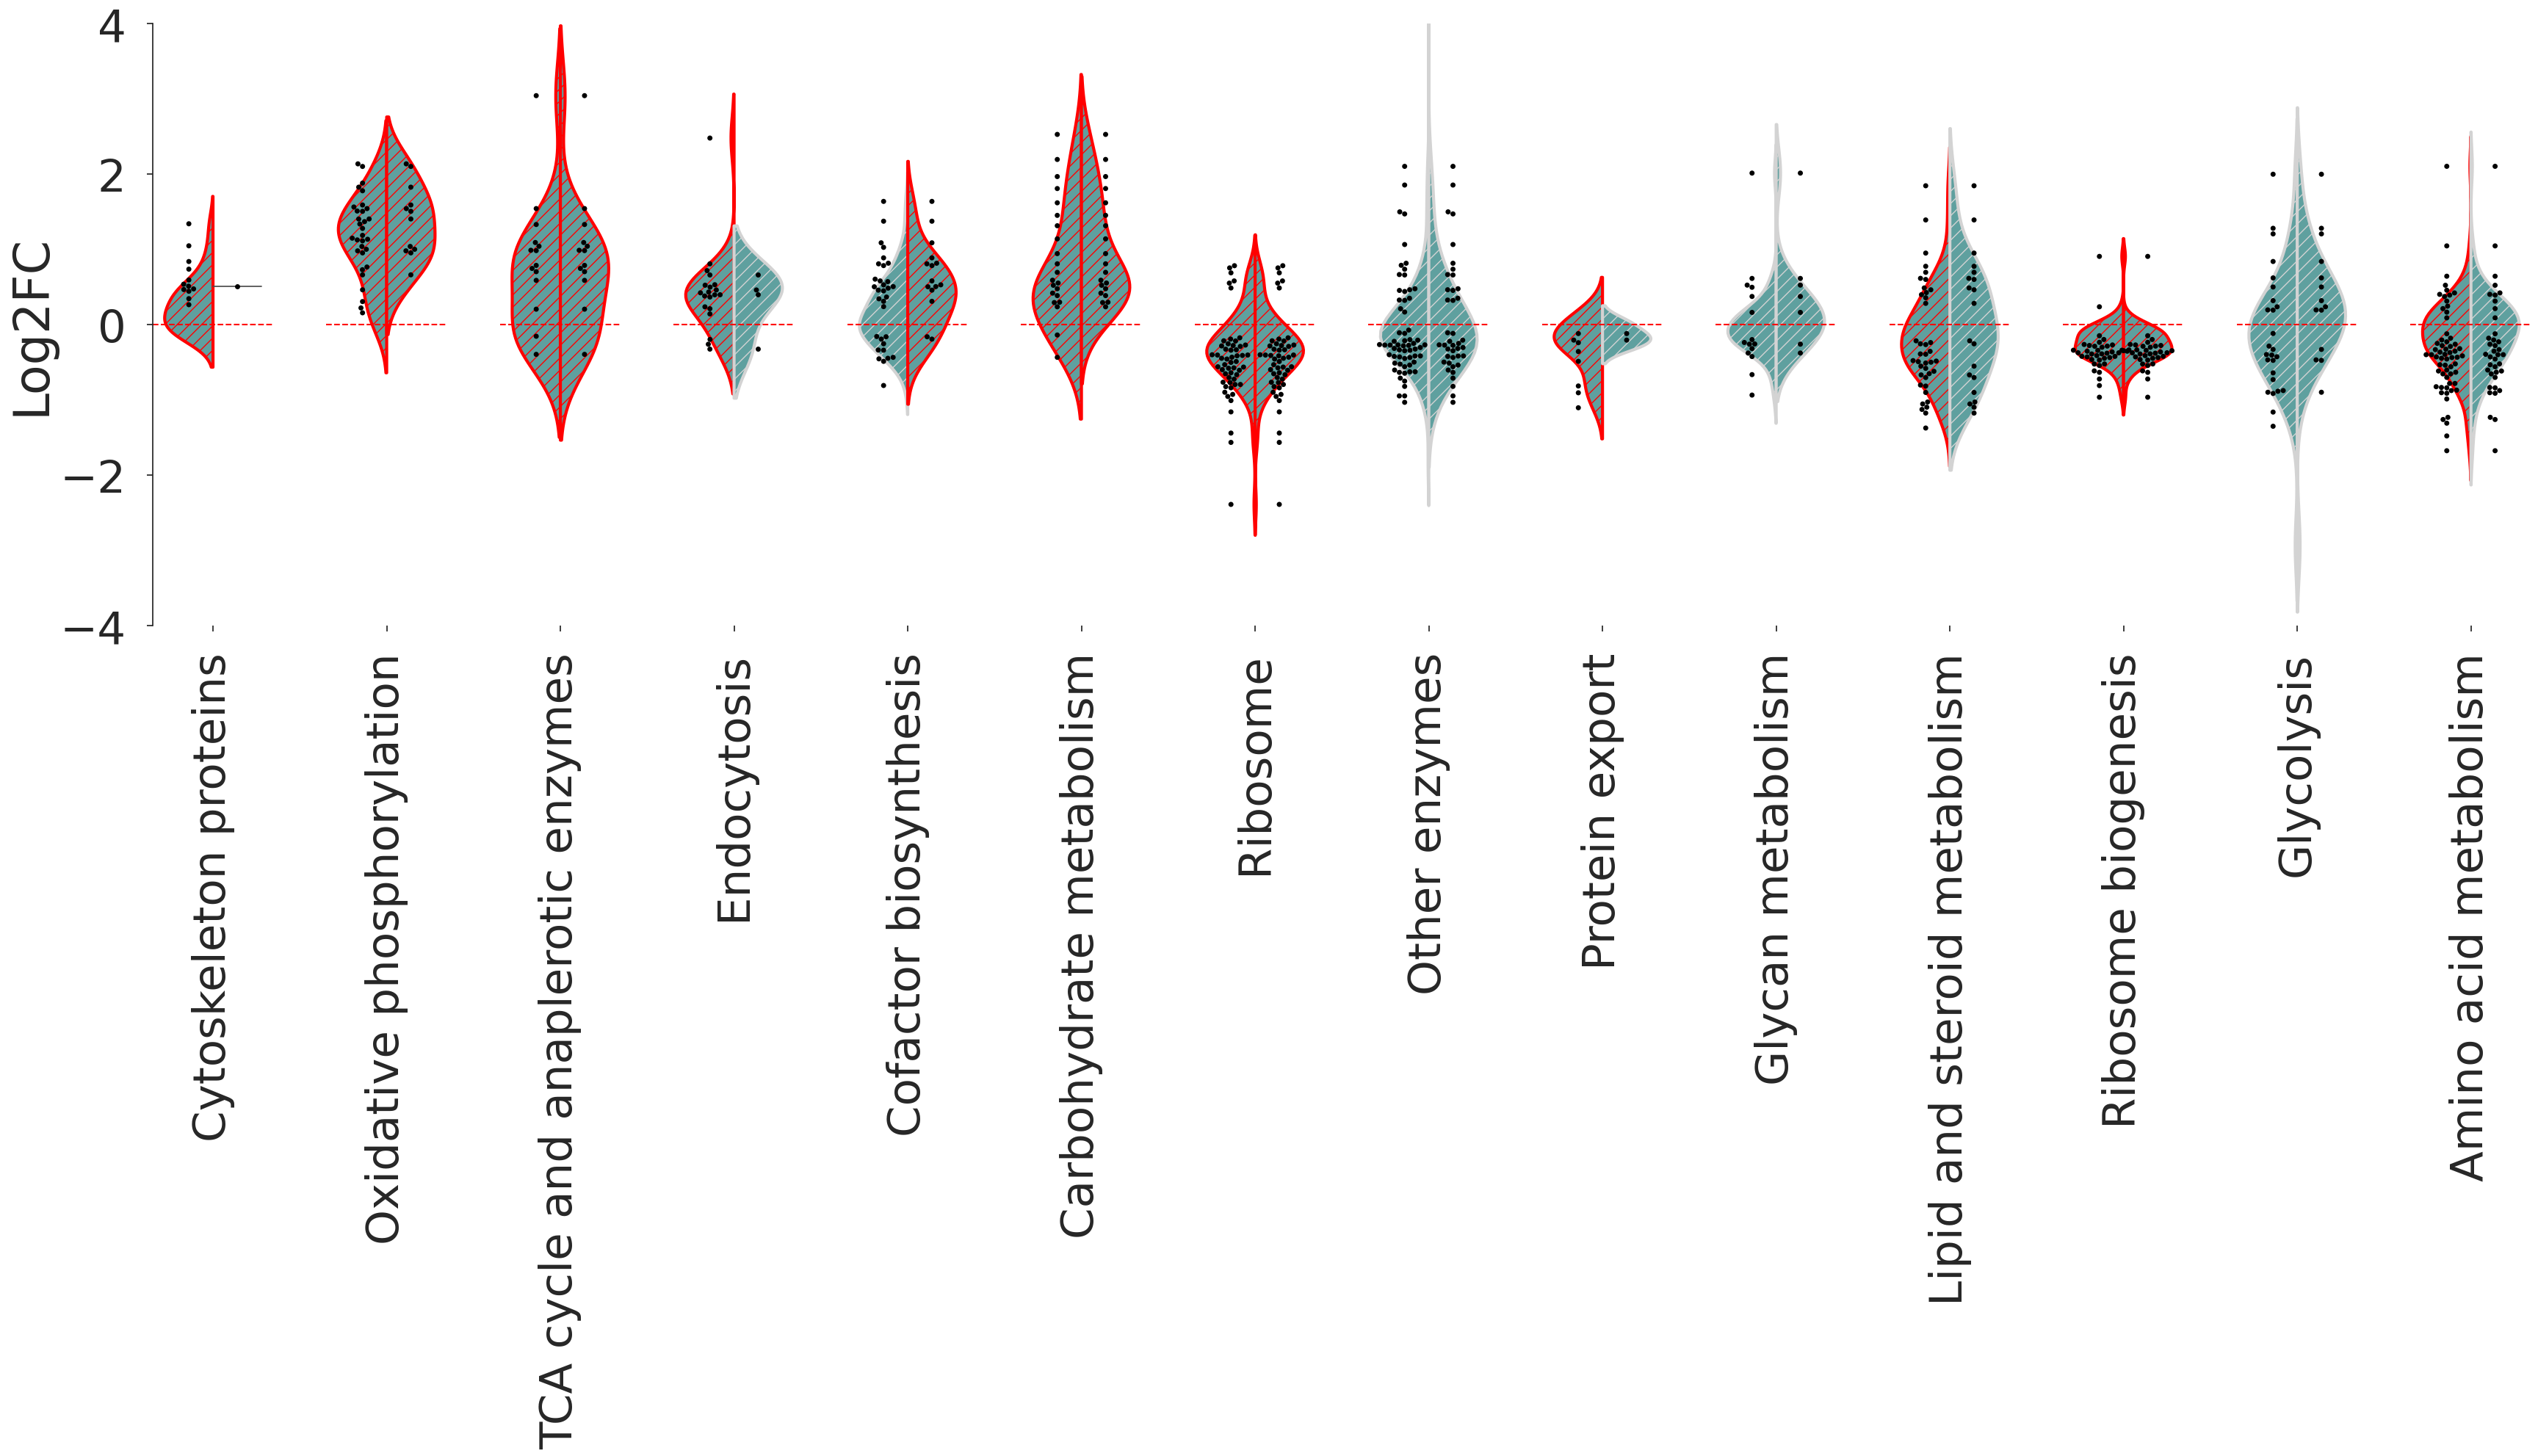

In [ ]:
# 全部とRapをヴァイオリンプロットで

#ーーーー有意差のあるLevel 3カテゴリーだけを抽出ーーーー

# all
significant_1 = Significant_Prot_all

# Rap
significant_2 = Significant_Prot_Rap

#ーーーーグラフのためのデータ準備ーーーー

# データを読み込む
df = pd.read_csv('nonzeroProteome_RNA.csv', delimiter=',')
#df = pd.read_csv('Proteome_RNA.csv', delimiter=',')

#RAPリストを読み込む
RAP = pd.read_excel("GR_ESR_Rap_list.xls")

# IDをキーとしてdfとRAPをマージ
df = pd.merge(df, RAP, on='ID')

#データフレームをスォームプロットのために加工
df.loc[df['Prot_FDR'] >= 0.05, 'Prot_FDR'] = None
df.loc[df['Prot_FDR'] < 0.05, 'Prot_FDR'] = df.loc[df['Prot_FDR'] < 0.05, 'Prot']

#Not mappedを削除
df = df.drop(df[df['Level 3'] == 'Not mapped'].index)

# level3_orderを含むデータだけ抽出
df = df.query('`Level 3` in @level3_order')

# Rap列がNaNではない（Rap）の場合異なる列に値をコピー
# df['Prot2'] = np.where(df['Rap'].isna(), df['Prot'], np.nan)
# df['Prot_FDR2'] = np.where(df['Rap'].isna(), df['Prot_FDR'], np.nan)

df['Prot2'] = np.where(df['Rap'].notna(), df['Prot'], np.nan)
df['Prot_FDR2'] = np.where(df['Rap'].notna(), df['Prot_FDR'], np.nan)

# 元の列と新しく作成した列をまとめてmelt
df_melt = pd.melt(df, id_vars=['Level 3'], value_vars=['Prot', 'Prot_FDR', 'Prot2', 'Prot_FDR2'], var_name='OP_protein', value_name='logFC')

# pd.Categorical関数を使用して、df内のLevel 3カラムを指定された順序で並べ替える
df_melt['Level 3'] = pd.Categorical(df_melt['Level 3'], categories=level3_order, ordered=True)

#NaN値エラーを防ぐ
df_melt = df_melt.dropna()

# 並べ替えたカテゴリに基づいて、グループ化されたデータフレームを作成する

grouped = df_melt.groupby('Level 3')
count = len(grouped)


#ーーーーグラフの描画ーーーー

# フォントをArialに設定、サイズを設定
plt.rcParams['font.family'] = 'Helvetica'
sns.set(font_scale=4)

# ヴァイオリンプロットを作成する

sns.set_style('white')
ncols = 20
nrows = math.ceil(count/ncols) +1

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(2.5*ncols, 15*nrows), sharey=True)

level3_categories = []  # Level 3 カテゴリのリストを初期化

for i, (name, group) in enumerate(grouped):
    row = i // ncols
    col = i % ncols

    level3_categories.append(name)  # Level 3 のカテゴリをリストに追加

    selected_hue_order_1 = ['Prot', 'Prot2']
    selected_hue_order_2 = ['Prot_FDR', 'Prot_FDR2']
    custom_palette = {'Prot': '#5FA09F', 'Prot2':'#5FA09F'}
    custom_palette_2 = {'Prot_FDR': 'black', 'Prot_FDR2': 'black'}


    # ヴァイオリンプロットを作成
    ax = sns.violinplot(x="Category", y='logFC', hue='OP_protein', data=group.assign(Category=name), ax=axs[row, col], scale='count', inner=None, split=True, hue_order=selected_hue_order_1, palette=custom_palette)

    # ストライプに
    for j, violin in enumerate(ax.collections):
        violin.set_hatch('//')
        violin.set_facecolor('#5FA09F')
        violin.set_linewidth(3)

        if j % 2 != 0:
            # 有意差あるものの枠線に色をつける
            if name in significant_2:
                violin.set_edgecolor('red')
            else:
                violin.set_edgecolor('lightgray')

        else:
            # 有意差あるものの枠線に色をつける
            if name in significant_1:
                violin.set_edgecolor('red')
            else:
                violin.set_edgecolor("lightgray")

    # スウォームプロットを作成
    sns.swarmplot(x="Category", y='logFC', hue='OP_protein', data=group.assign(Category=name), ax=axs[row, col], dodge=True, hue_order=selected_hue_order_2, palette=custom_palette_2, size=5)

    axs[row, col].set_ylabel('')     #個別のグラフの軸ラベルを消す
    axs[row, col].set_xlabel('')     #個別のグラフの軸ラベルを消す
    axs[row, col].set_xticklabels(axs[row, col].get_xticklabels(), rotation=90)     # X軸のラベルを90度回転

    if col != 0:
        axs[row, col].yaxis.set_ticks_position('none')  # Y軸の目盛り線を削除
        axs[row, col].spines['left'].set_visible(False)  # Y軸の線を削除
        axs[row, col].set_ylabel('')  # Y軸ラベルを削除
    else:
        axs[row, col].yaxis.set_ticks_position('left')  # Y軸の目盛り線を左側に表示
        axs[row, col].set_ylabel('Log2FC')

    axs[row, col].xaxis.set_ticks_position('bottom')
    axs[row, col].spines['bottom'].set_visible(False)  # X軸の線を削除
    axs[row, col].axhline(y=0, color='red', linestyle='--')
    axs[row, col].set_ylim(-4, 4)
    axs[row, col].legend().set_visible(False)
    axｓ[row, col].tick_params(axis='both', which='both', pad=20) # 軸の目盛りラベルを軸から離す

    # 上部の枠線を非表示にする
    axs[row, col].spines['top'].set_visible(False)
    # 右側の枠線を非表示にする
    axs[row, col].spines['right'].set_visible(False)

for j in range(i + 1, nrows * ncols):
    row = j // ncols
    col = j % ncols
    fig.delaxes(axs[row][col])  # 余分なサブプロットを削除

plt.tight_layout()
#plt.subplots_adjust(wspace=0, hspace=0.5)  # subplot間の間隔を調整
#plt.subplots_adjust(bottom=0.8, top=12)
plt.show()

['Oxidative phosphorylation', 'Ribosome', 'Ribosome biogenesis', 'Carbohydrate metabolism', 'Amino acid metabolism', 'Endocytosis', 'Lipid and steroid metabolism', 'Cytoskeleton proteins', 'TCA cycle and anaplerotic enzymes', 'Protein export']
['Oxidative phosphorylation', 'Glycolysis', 'Amino acid metabolism', 'Lipid and steroid metabolism', 'Endocytosis', 'Protein export', 'Cytoskeleton proteins', 'Other enzymes', 'Glycan metabolism']


<ipython-input-67-89e9c3ab8214>:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_melt.groupby('Level 3')
<ipython-input-67-89e9c3ab8214>:82: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='count'` for the same effect.
  ax = sns.violinplot(x="Category", y='logFC', hue='OP_protein', data=group.assign(Category=name), ax=axs[row, col], scale='count', inner=None, split=True, hue_order=selected_hue_order_1, palette=custom_palette)
<ipython-input-67-89e9c3ab8214>:109: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[row, col].set_xticklabels(axs[row, col].get_xticklabels(), rotation=90)     # X軸のラベルを90度回転
<ipython-input-67-89e9c3ab8214>:82: Future

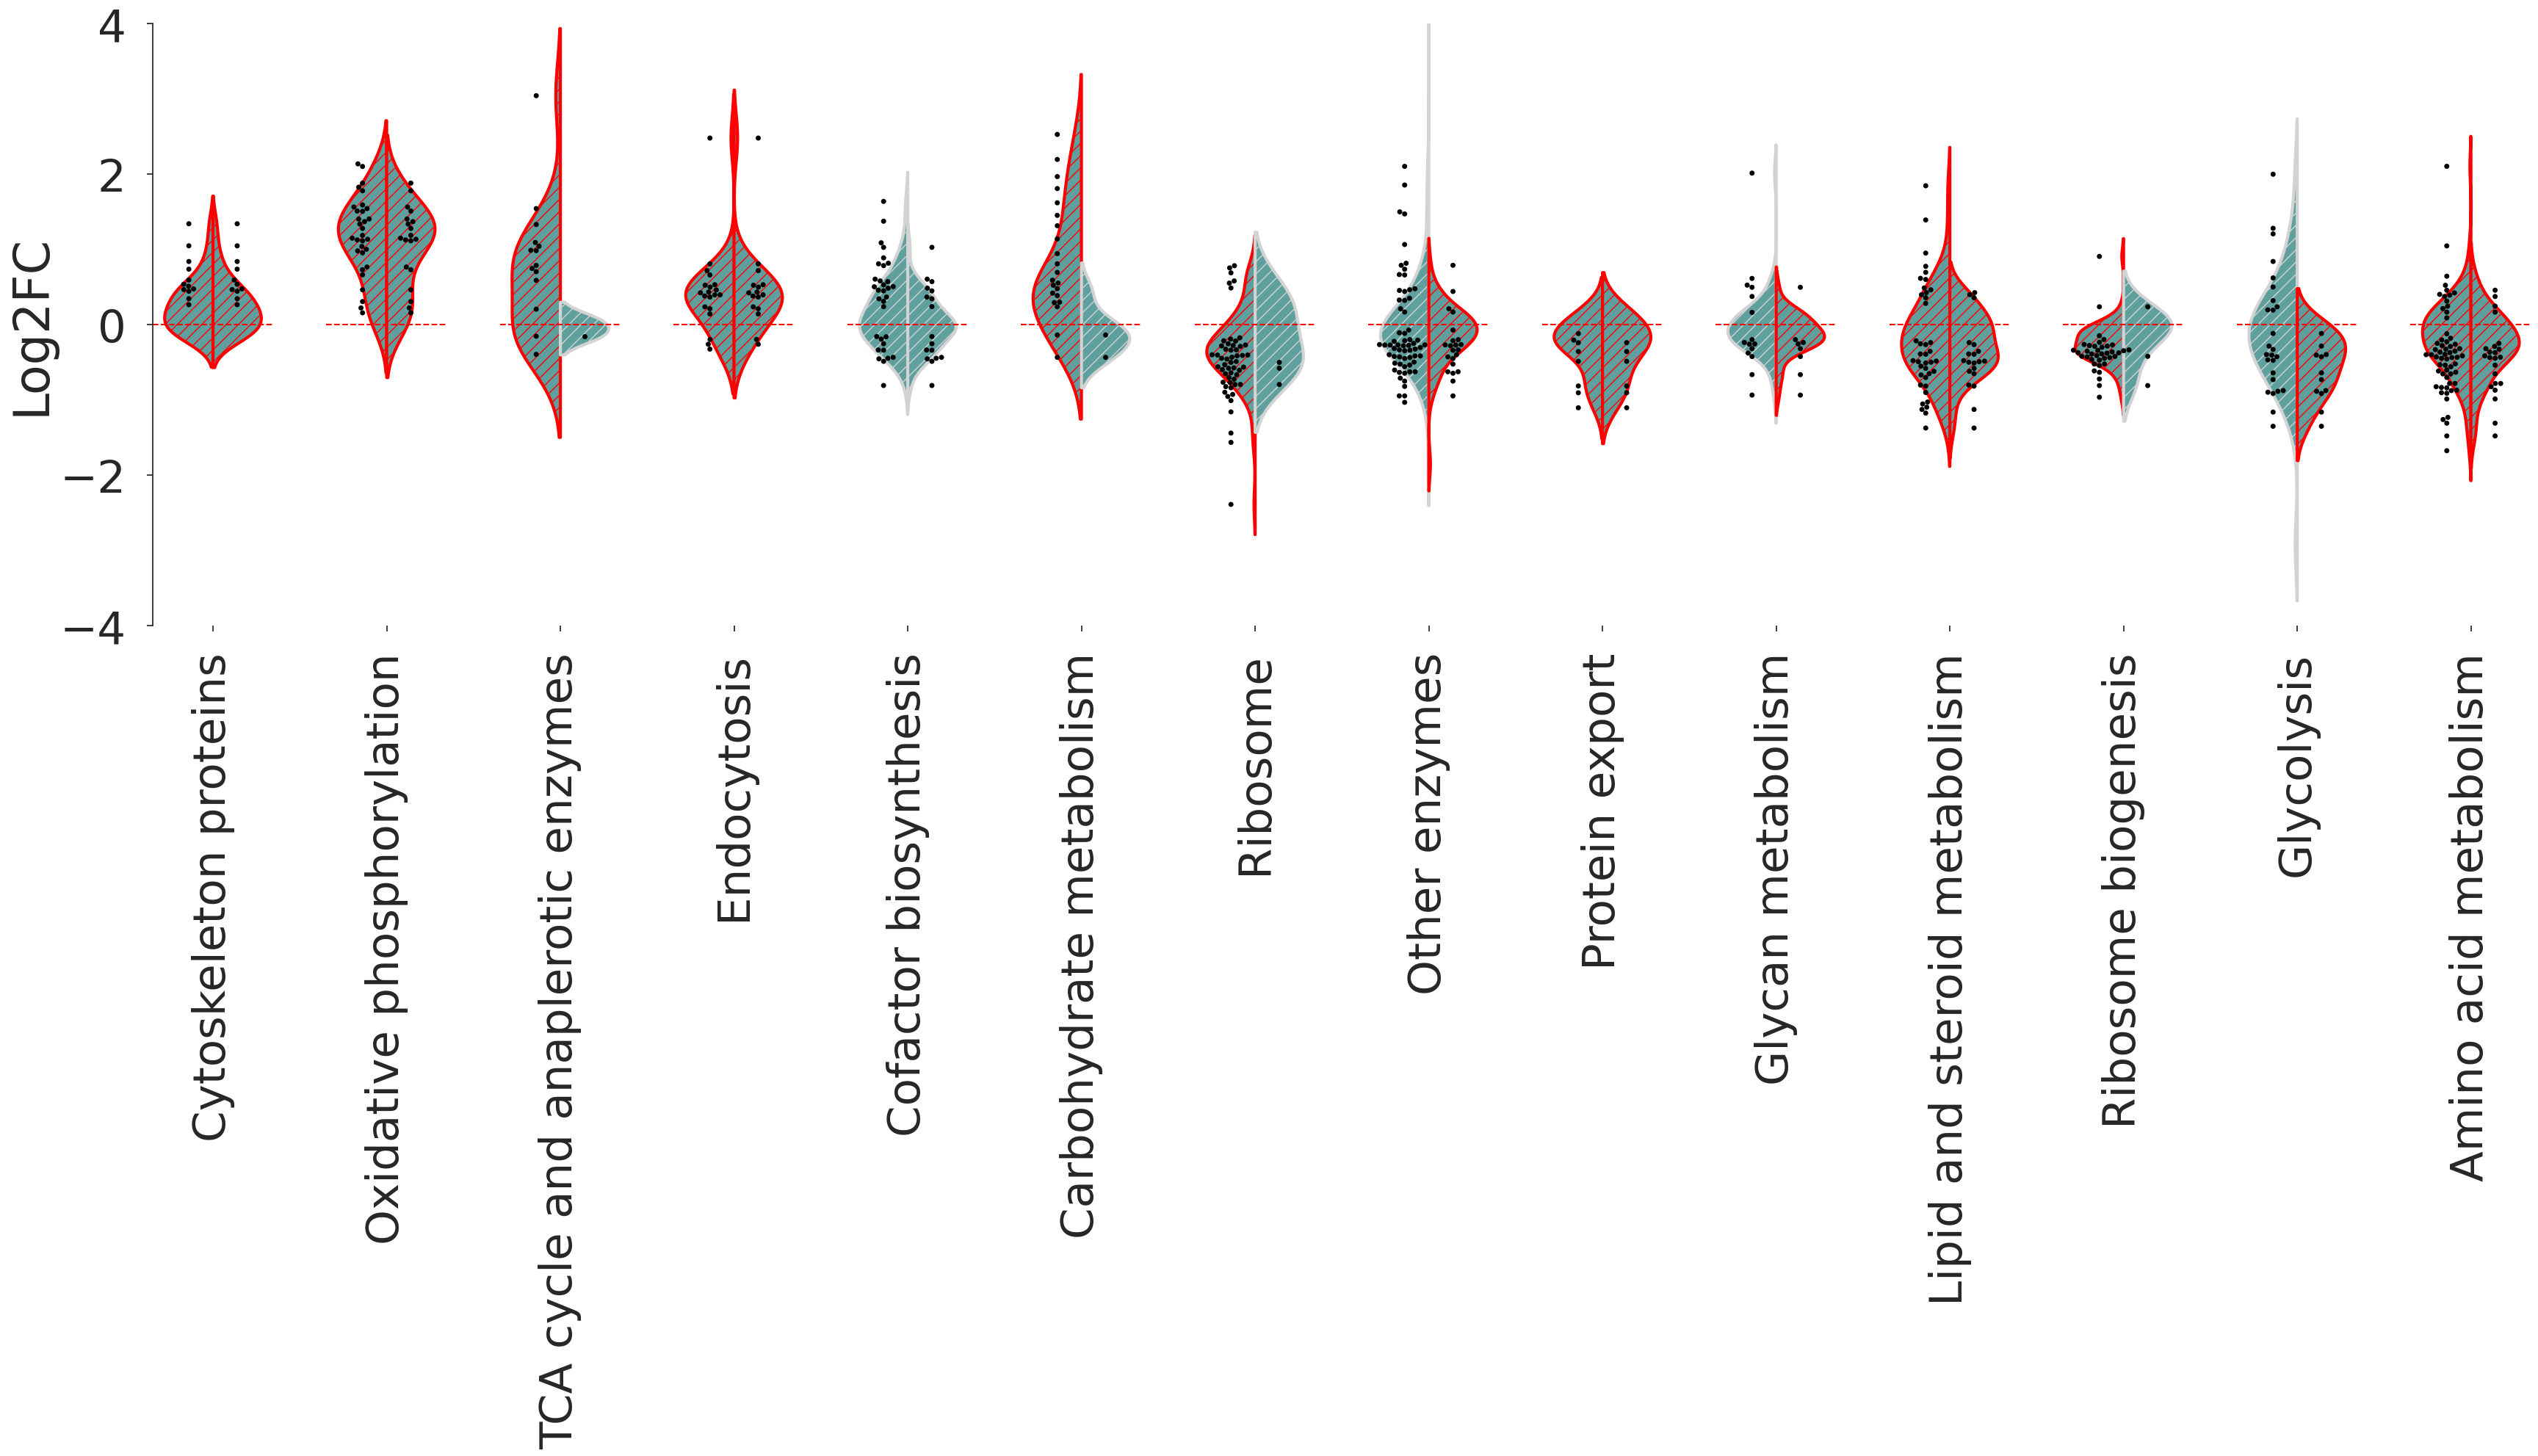

In [ ]:
# 全部とnonRapをヴァイオリンプロットで

#ーーーー有意差のあるLevel 3カテゴリーだけを抽出ーーーー

# all
significant_1 = Significant_Prot_all
print(significant_1)

# Rap
significant_2 = Significant_Prot_nonRap
print(significant_2)

#ーーーーグラフのためのデータ準備ーーーー

# データを読み込む
df = pd.read_csv('nonzeroProteome_RNA.csv', delimiter=',')
#df = pd.read_csv('Proteome_RNA.csv', delimiter=',')

#RAPリストを読み込む
RAP = pd.read_excel("GR_ESR_Rap_list.xls")

# IDをキーとしてdfとRAPをマージ
df = pd.merge(df, RAP, on='ID')

#データフレームをスォームプロットのために加工
df.loc[df['Prot_FDR'] >= 0.05, 'Prot_FDR'] = None
df.loc[df['Prot_FDR'] < 0.05, 'Prot_FDR'] = df.loc[df['Prot_FDR'] < 0.05, 'Prot']

#Not mappedを削除
df = df.drop(df[df['Level 3'] == 'Not mapped'].index)

# level3_orderを含むデータだけ抽出
df = df.query('`Level 3` in @level3_order')

# Rap列がNaN(nonRap)を選別
df['Prot2'] = np.where(df['Rap'].isna(), df['Prot'], np.nan)
df['Prot_FDR2'] = np.where(df['Rap'].isna(), df['Prot_FDR'], np.nan)

# 元の列と新しく作成した列をまとめてmelt
df_melt = pd.melt(df, id_vars=['Level 3'], value_vars=['Prot', 'Prot_FDR', 'Prot2', 'Prot_FDR2'], var_name='OP_protein', value_name='logFC')

# pd.Categorical関数を使用して、df内のLevel 3カラムを指定された順序で並べ替える
df_melt['Level 3'] = pd.Categorical(df_melt['Level 3'], categories=level3_order, ordered=True)

#NaN値エラーを防ぐ
df_melt = df_melt.dropna()

# 並べ替えたカテゴリに基づいて、グループ化されたデータフレームを作成する

grouped = df_melt.groupby('Level 3')
count = len(grouped)

#ーーーーグラフの描画ーーーー

# フォントをArialに設定、サイズを設定
plt.rcParams['font.family'] = 'Helvetica'
sns.set(font_scale=4)

# ヴァイオリンプロットを作成する

sns.set_style('white')
ncols = 20
nrows = math.ceil(count/ncols) +1

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(2.5*ncols, 15*nrows), sharey=True)

level3_categories = []  # Level 3 カテゴリのリストを初期化

for i, (name, group) in enumerate(grouped):
    row = i // ncols
    col = i % ncols

    level3_categories.append(name)  # Level 3 のカテゴリをリストに追加

    selected_hue_order_1 = ['Prot', 'Prot2']
    selected_hue_order_2 = ['Prot_FDR', 'Prot_FDR2']
    custom_palette = {'Prot': '#5FA09F', 'Prot2':'#5FA09F'}
    custom_palette_2 = {'Prot_FDR': 'black', 'Prot_FDR2': 'black'}


    # ヴァイオリンプロットを作成
    ax = sns.violinplot(x="Category", y='logFC', hue='OP_protein', data=group.assign(Category=name), ax=axs[row, col], scale='count', inner=None, split=True, hue_order=selected_hue_order_1, palette=custom_palette)

    # ストライプに
    for j, violin in enumerate(ax.collections):
        violin.set_hatch('//')
        violin.set_facecolor('#5FA09F')
        violin.set_linewidth(3)
        if j % 2 != 0:
            # 有意差あるものの枠線に色をつける
            if name in significant_2:
                violin.set_edgecolor('red')
            else:
                violin.set_edgecolor('lightgray')

        else:
            # 有意差あるものの枠線に色をつける

            if name in significant_1:
                violin.set_edgecolor('red')
            else:
                violin.set_edgecolor("lightgray")

    # スウォームプロットを作成
    sns.swarmplot(x="Category", y='logFC', hue='OP_protein', data=group.assign(Category=name), ax=axs[row, col], dodge=True, hue_order=selected_hue_order_2, palette=custom_palette_2, size=5)

    axs[row, col].set_ylabel('')     #個別のグラフの軸ラベルを消す
    axs[row, col].set_xlabel('')     #個別のグラフの軸ラベルを消す
    axs[row, col].set_xticklabels(axs[row, col].get_xticklabels(), rotation=90)     # X軸のラベルを90度回転

    if col != 0:
        axs[row, col].yaxis.set_ticks_position('none')  # Y軸の目盛り線を削除
        axs[row, col].spines['left'].set_visible(False)  # Y軸の線を削除
        axs[row, col].set_ylabel('')  # Y軸ラベルを削除
    else:
        axs[row, col].yaxis.set_ticks_position('left')  # Y軸の目盛り線を左側に表示
        axs[row, col].set_ylabel('Log2FC')

    axs[row, col].xaxis.set_ticks_position('bottom')
    axs[row, col].spines['bottom'].set_visible(False)  # X軸の線を削除
    axs[row, col].axhline(y=0, color='red', linestyle='--')
    axs[row, col].set_ylim(-4, 4)
    axs[row, col].legend().set_visible(False)
    axｓ[row, col].tick_params(axis='both', which='both', pad=20) # 軸の目盛りラベルを軸から離す

    # 上部の枠線を非表示にする
    axs[row, col].spines['top'].set_visible(False)
    # 右側の枠線を非表示にする
    axs[row, col].spines['right'].set_visible(False)

for j in range(i + 1, nrows * ncols):
    row = j // ncols
    col = j % ncols
    fig.delaxes(axs[row][col])  # 余分なサブプロットを削除

plt.tight_layout()
#plt.subplots_adjust(wspace=0, hspace=0.5)  # subplot間の間隔を調整
#plt.subplots_adjust(bottom=0.8, top=12)
plt.show()

# 撒布図 (Transcriptome)
Transcriptome, mox vs mox-YG, original Figure 4


値が0以上の行数: 187
値が0以下の行数: 290
moxの値が0以上の行数: 132
moxの値が0以下の行数: 217
moxYGの値が0以上の行数: 321
moxYGの値が0以下の行数: 298


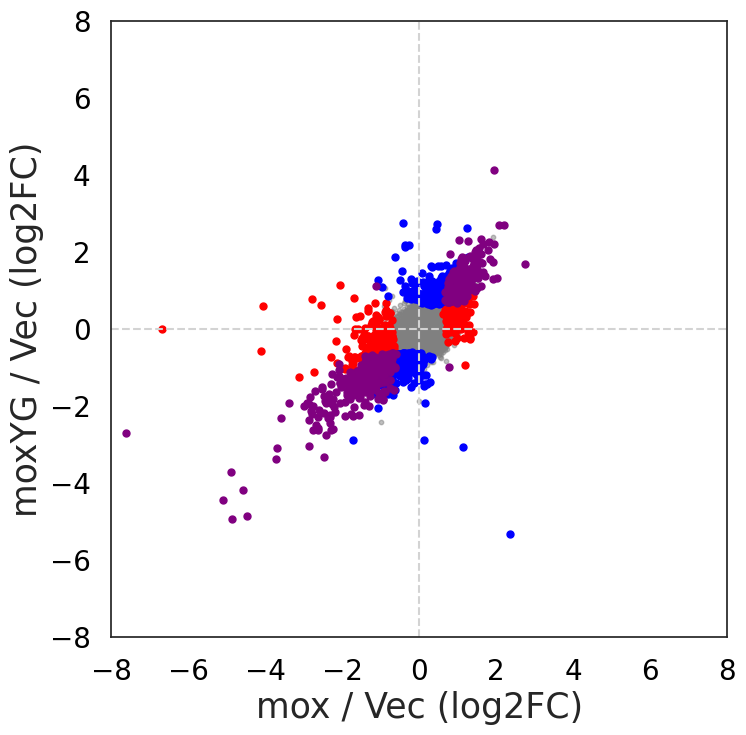

In [ ]:
#RNA mox vs moxYG

# データを読み込む
df = pd.read_excel('RNAseq.xlsx')
gene_list = pd.read_excel('SGA_gene_list.xlsx')

df = pd.merge(df, gene_list, on='ID')
df = df.dropna()

# ピアソン相関係数を計算
corr = np.corrcoef(df['mox'], df['moxYG'])[0, 1]

#print('ピアソン相関係数:', corr)

# logCPMカラムが0より大きい行だけを抽出
df = df[df['logCPM'] > 0]

# mox_FDRが0.05以下またはmoxYG_FDRが0.05以下のデータを抽出
filtered_df_or = df[(df['mox_FDR'] <= 0.05) | (df['moxYG_FDR'] <= 0.05)]

# mox_FDRが0.05以下かつmoxYG_FDRが0.05以下のデータを抽出
filtered_df_and = df[(df['mox_FDR'] <= 0.05) & (df['moxYG_FDR'] <= 0.05)]

# mox列の値が0以上の行数を数える
num_rows_positive = len(filtered_df_and[filtered_df_and['mox'] >= 0])
print("値が0以上の行数:", num_rows_positive)

# mox列の値が0以下の行数を数える
num_rows_negative = len(filtered_df_and[filtered_df_and['mox'] <= 0])
print("値が0以下の行数:", num_rows_negative)

# mox_FDRが0.05以下のデータを抽出
filtered_df_mox = df[df['mox_FDR'] < 0.05]

# df1から、df2にも含まれるIDを持つ行を削除する
filtered_df_mox = filtered_df_mox[~filtered_df_mox['ID'].isin(filtered_df_and['ID'])]

# mox列の値が0以上の行数を数える
num_rows_mox_positive = len(filtered_df_mox[filtered_df_mox['mox'] >= 0])
print("moxの値が0以上の行数:", num_rows_mox_positive)

# mox列の値が0以下の行数を数える
num_rows_mox_negative = len(filtered_df_mox[filtered_df_mox['mox'] <= 0])
print("moxの値が0以下の行数:", num_rows_mox_negative)

# moxYG_FDRが0.05以下のデータを抽出
filtered_df_moxYG = df[df['moxYG_FDR'] < 0.05]

# df1から、df2にも含まれるIDを持つ行を削除する
filtered_df_moxYG = filtered_df_moxYG[~filtered_df_moxYG['ID'].isin(filtered_df_and['ID'])]

# mox列の値が0以上の行数を数える
num_rows_moxYG_positive = len(filtered_df_moxYG[filtered_df_moxYG['moxYG'] >= 0])
print("moxYGの値が0以上の行数:", num_rows_moxYG_positive)

# mox列の値が0以下の行数を数える
num_rows_moxYG_negative = len(filtered_df_moxYG[filtered_df_moxYG['moxYG'] <= 0])
print("moxYGの値が0以下の行数:", num_rows_moxYG_negative)


# グラフの作成
fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(df['mox'], df['moxYG'], s=10, alpha=0.5, color='gray')

# フィルタリングされたデータフレームのmoxとmoxYGの散布図を赤で描画
plt.scatter(filtered_df_mox['mox'], filtered_df_mox['moxYG'], s=25, color='red',)

# フィルタリングされたデータフレームのmoxとmoxYGの散布図を青で描画
plt.scatter(filtered_df_moxYG['mox'], filtered_df_moxYG['moxYG'], s=25, color='Blue')

# フィルタリングされたデータフレームのmoxとmoxYGの散布図を紫で描画
plt.scatter(filtered_df_and['mox'], filtered_df_and['moxYG'], s=25, color='purple')

# フィルタリングされたデータフレームのmoxとmoxYGの散布図をオレンジで描画
#plt.scatter(filtered_df_or['mox'], filtered_df_or['moxYG'], s=15, color='orange')


# グラフのタイトル、軸ラベル、軸目盛のフォントサイズを指定
ax.set_xlabel('mox / Vec (log2FC)', fontsize=25)
ax.set_ylabel('moxYG / Vec (log2FC)', fontsize=25)

# アスペクト比を等しく設定
ax.set_aspect('equal', adjustable='box')

# X軸とY軸の範囲を-6から6に設定します
ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)

# x軸とy軸のtickの位置を設定
ax.set_xticks(range(-8, 9, 2))
ax.set_yticks(range(-8, 9, 2))

# tickのスタイルやフォントサイズを設定
ax.tick_params(axis='both', which='major', labelsize=20, length=5, width=1, direction='out', pad=10, colors='black')

# 0を線で示します
ax.axhline(y=0, color='lightgray', linestyle='--')
ax.axvline(x=0, color='lightgray', linestyle='--')

# レジェンドをグラフの外に配置します
#plt.legend(['mox vs moxYG'], loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

# 撒布図 (Transcriptome vs Proteome)
mox-YG/vector, new Figure Sx


ピアソン相関係数: 0.136215974626283
値が0以上の行数: 176
値が0以下の行数: 170
RNAの値が0以上の行数: 151
RNAの値が0以下の行数: 222
Protの値が0以上の行数: 639
Protの値が0以下の行数: 676


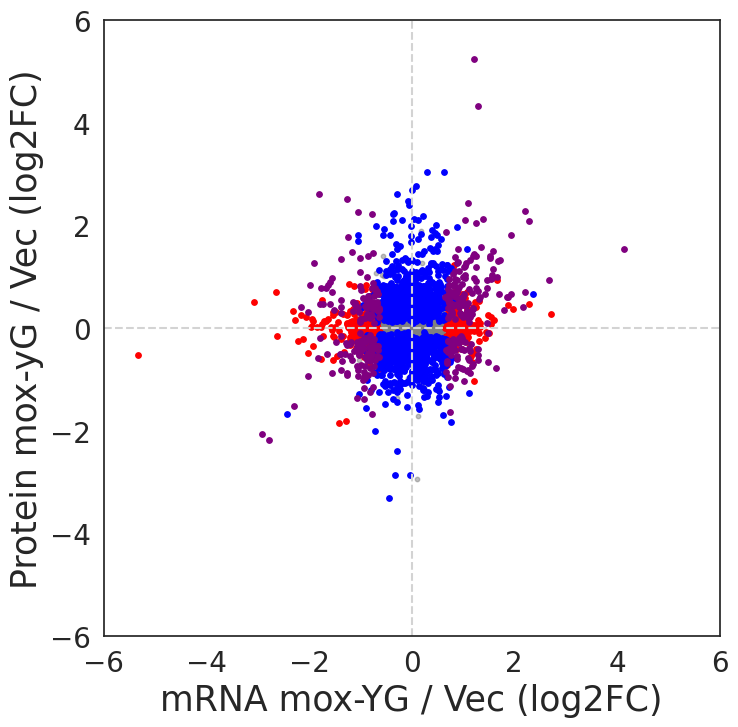

In [85]:
#Prot Proteome vs RNAの散布図

# データを読み込む
df = pd.read_csv('nonzeroProteome_RNA.csv')

# ピアソン相関係数を計算
corr = np.corrcoef(df['Prot'], df['RNA'])[0, 1]

print('ピアソン相関係数:', corr)

# RNA_FDRが0.05以下またはProt_FDRが0.05以下のデータを抽出
filtered_df_or = df[(df['RNA_FDR'] <= 0.05) | (df['Prot_FDR'] <= 0.05)]

# RNA_FDRが0.05以下かつProt_FDRが0.05以下のデータを抽出
filtered_df_and = df[(df['RNA_FDR'] <= 0.05) & (df['Prot_FDR'] <= 0.05)]

# RNA列の値が0以上の行数を数える
num_rows_positive = len(filtered_df_and[filtered_df_and['RNA'] >= 0])
print("値が0以上の行数:", num_rows_positive)

# RNA列の値が0以下の行数を数える
num_rows_negative = len(filtered_df_and[filtered_df_and['RNA'] <= 0])
print("値が0以下の行数:", num_rows_negative)

# RNA_FDRが0.05以下のデータを抽出
filtered_df_RNA = df[df['RNA_FDR'] < 0.05]

# df1から、df2にも含まれるIDを持つ行を削除する
filtered_df_RNA = filtered_df_RNA[~filtered_df_RNA['ID'].isin(filtered_df_and['ID'])]


# RNA列の値が0以上の行数を数える
num_rows_RNA_positive = len(filtered_df_RNA[filtered_df_RNA['RNA'] >= 0])
print("RNAの値が0以上の行数:", num_rows_RNA_positive)

# RNA列の値が0以下の行数を数える
num_rows_RNA_negative = len(filtered_df_RNA[filtered_df_RNA['RNA'] <= 0])
print("RNAの値が0以下の行数:", num_rows_RNA_negative)


# Prot_FDRが0.05以下のデータを抽出
filtered_df_Prot = df[df['Prot_FDR'] < 0.05]

# df1から、df2にも含まれるIDを持つ行を削除する
filtered_df_Prot = filtered_df_Prot[~filtered_df_Prot['ID'].isin(filtered_df_and['ID'])]

# RNA列の値が0以上の行数を数える
num_rows_Prot_positive = len(filtered_df_Prot[filtered_df_Prot['Prot'] >= 0])
print("Protの値が0以上の行数:", num_rows_Prot_positive)

# RNA列の値が0以下の行数を数える
num_rows_Prot_negative = len(filtered_df_Prot[filtered_df_Prot['Prot'] <= 0])
print("Protの値が0以下の行数:", num_rows_Prot_negative)


# グラフの作成
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(df['RNA'], df['Prot'], s=10, alpha=0.5, color='gray')


# フィルタリングされたデータフレームのRNAとProtの散布図を赤で描画
plt.scatter(filtered_df_RNA['RNA'], filtered_df_RNA['Prot'], s=15, color='red',)

# フィルタリングされたデータフレームのRNAとProtの散布図を青で描画
plt.scatter(filtered_df_Prot['RNA'], filtered_df_Prot['Prot'], s=15, color='Blue')

# フィルタリングされたデータフレームのRNAとProtの散布図を紫で描画
plt.scatter(filtered_df_and['RNA'], filtered_df_and['Prot'], s=15, color='purple')

# フィルタリングされたデータフレームのRNAとProtの散布図をオレンジで描画
#plt.scatter(filtered_df_or['RNA'], filtered_df_or['Prot'], s=15, color='orange')


# グラフのタイトル、軸ラベル、軸目盛のフォントサイズを指定
ax.set_xlabel('mRNA mox-YG / Vec (log2FC)', fontsize=25)
ax.set_ylabel('Protein mox-yG / Vec (log2FC)', fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=20)

# アスペクト比を等しく設定
ax.set_aspect('equal', adjustable='box')

# X軸とY軸の範囲を-6から6に設定します
ax.set_xlim(-6, 6)
ax.set_ylim(-6, 6)

# # X軸の区切りを2ずつに設定し、小数点以下を非表示にします
# ax.set_xticks(range(-8, 9, 2))
# #ax.xaxis.set_major_formatter('{x:.0f}')


# 0を線で示します
ax.axhline(y=0, color='lightgray', linestyle='--')
ax.axvline(x=0, color='lightgray', linestyle='--')

# レジェンドをグラフの外に配置します
#plt.legend(['RNA vs Prot'], loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

# ベン図
Rapとmox/moxYGの比較

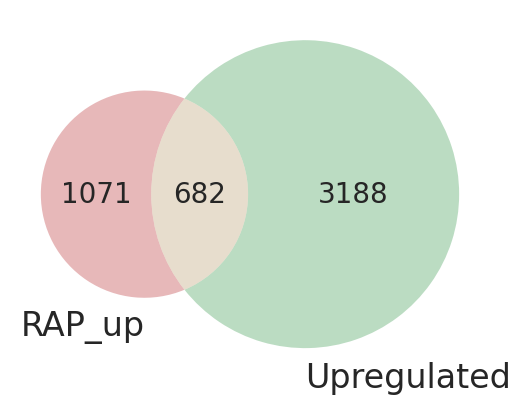

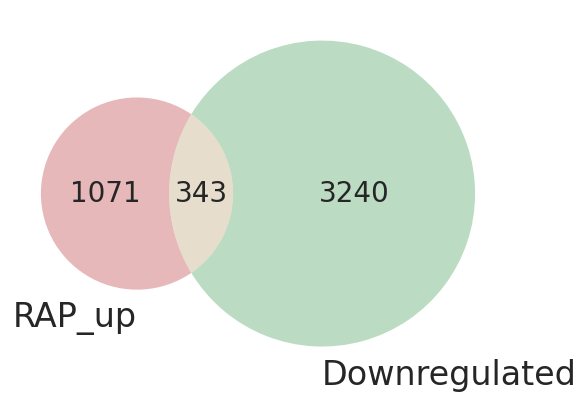

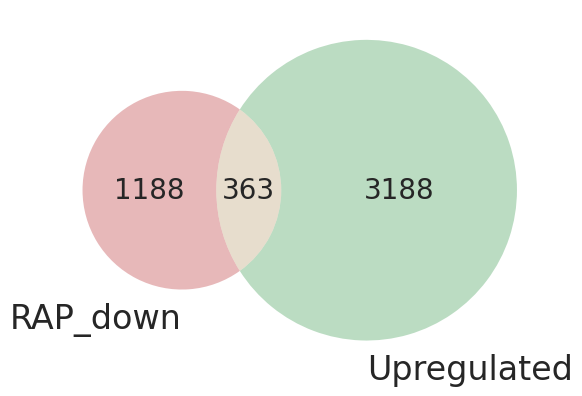

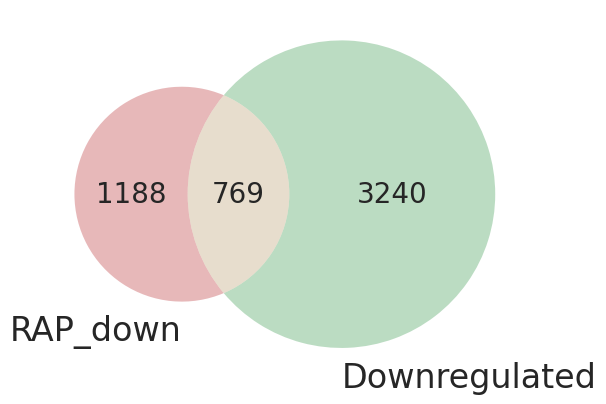

In [ ]:
# データの読み込み
data = pd.read_excel("/content/drive/MyDrive/KEGG/MOXvsMOXYG_Re.xlsx")

# FDR < 0.05 かつ logFC > 0 のデータを抽出
upregulated = data[(data['FDR'] < 1) & (data['logFC'] > 0)]
#upregulated = data[(data['FDR'] < 0.05) & (data['logFC'] > 0)]

# FDR < 0.05 かつ logFC < 0 のデータを抽出
downregulated = data[(data['FDR'] < 1) & (data['logFC'] < 0)]
#downregulated = data[(data['FDR'] < 0.05) & (data['logFC'] < 0)]

# RAPデータの読み込み
RAP = pd.read_excel('GR_ESR_Rap_list.xls')
RAP_up = RAP[RAP['Rap'] == 'up']
RAP_down = RAP[RAP['Rap'] == 'down']

# ベン図1: RAP_up と Upregulated
num_common_up_up = upregulated[upregulated['ID'].isin(RAP_up['ID'])].shape[0]
venn2(subsets=(RAP_up.shape[0], upregulated.shape[0], num_common_up_up), set_labels=('RAP_up', 'Upregulated'))
plt.show()

# ベン図2: RAP_up と Downregulated
num_common_up_down = downregulated[downregulated['ID'].isin(RAP_up['ID'])].shape[0]
venn2(subsets=(RAP_up.shape[0], downregulated.shape[0], num_common_up_down), set_labels=('RAP_up', 'Downregulated'))
plt.show()

# ベン図3: RAP_down と Upregulated
num_common_down_up = upregulated[upregulated['ID'].isin(RAP_down['ID'])].shape[0]
venn2(subsets=(RAP_down.shape[0], upregulated.shape[0], num_common_down_up), set_labels=('RAP_down', 'Upregulated'))
plt.show()

# ベン図4: RAP_down と Downregulated
num_common_down_down = downregulated[downregulated['ID'].isin(RAP_down['ID'])].shape[0]
venn2(subsets=(RAP_down.shape[0], downregulated.shape[0], num_common_down_down), set_labels=('RAP_down', 'Downregulated'))
plt.show()